# Project 1 - Supervised learning


# Outline


- [Task 1](#task-1): Regression <a name="index-task-1"></a>
  - [(1.1)](#task-11) Random Forest <a name="index-task-11"></a>
    - [(1.1.1)](#task-111) <a name="index-task-111"></a>
    - [(1.1.2)](#task-112) <a name="index-task-112"></a>
    - [(1.1.3)](#task-113) <a name="index-task-113"></a>
  - [(1.2)](#task-12) Multi-layer Perceptron <a name="index-task-12"></a>
    - [(1.2.1)](#task-121) <a name="index-task-121"></a>
    - [(1.2.2)](#task-122) <a name="index-task-122"></a>
    - [(1.2.3)](#task-123) <a name="index-task-123"></a>
- [Task 2](#task-2): Classification <a name="index-task-2"></a>
  - [(2.1)](#task-21) k-Nearest Neighbours <a name="index-task-21"></a>
    - [(2.1.1)](#task-211)  <a name="index-task-211"></a>
    - [(2.1.2)](#task-212) <a name="index-task-212"></a>
    - [(2.1.3)](#task-213) <a name="index-task-213"></a>
  - [(2.2)](#task-22) Logistic regression vs kernel logistic regression <a name="index-task-22"></a>
    - [(2.2.1)](#task-221) <a name="index-task-221"></a>
    - [(2.2.2)](#task-222) <a name="index-task-222"></a>
    - [(2.2.3)](#task-223) <a name="index-task-223"></a>



---



In [1]:
# import
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm.notebook import tqdm
import pandas as pd

<a name="task-1"></a>

# (1) Task 1: Regression [(index)](#index-task-1)

In [2]:
# Read data
nano_data = pd.read_csv('./nanoelectrodes_capacitance_samples.csv')
nano_data_test = pd.read_csv('./nanoelectrodes_capacitance_test.csv')


# Move Capacitance to the last column as this is the feature we wish to work with 
moved_column = nano_data.pop('Capacitance ($\mu F / cm^2$)')
nano_data.insert(len(nano_data.columns),'Capacitance ($\mu F / cm^2$)', moved_column)

moved_column_test = nano_data_test.pop('Capacitance ($\mu F / cm^2$)')
nano_data_test.insert(len(nano_data_test.columns),'Capacitance ($\mu F / cm^2$)', moved_column_test)


# Check data
print(nano_data.shape)
nano_data.tail(10)

# Define a dataframe of features and a vector of our regression variable
X_nano = nano_data[nano_data.columns[:-1]]
y_nano = nano_data[nano_data.columns[-1]]

# Define a dataframe of features and a vector of our regression variable
X_nano_test = nano_data_test[nano_data_test.columns[:-1]]
y_nano_test = nano_data_test[nano_data_test.columns[-1]]

# Define a numpy array corresponding to X_nano and y_nano
X_nano_arr = X_nano.to_numpy()
y_nano_arr = y_nano.to_numpy()

columns_dict = {index: False for index in range(X_nano.shape[1])}

(558, 13)


In [3]:
def mse(a,b):

    return np.mean((a-b)**2)

<a name="task-11"></a>

## (1.1) Random Forest [(index)](#index-task-11)

First we define a standardise function to utilise throughout our coursework

In [4]:
def standardise(X, X_train_=None):
    """Standardise features.

    Parameters:
        X (np.array): Feature matrix.
        X_train_ (np.array): An optional feature matrix to compute the statistics
            from before applying it to X. If None, just use X to compute the statistics.

    Returns:
        X_std (np.array): Standardised feature matrix
    """
    if X_train_ is None:
        X_train_ = X

    mu = np.mean(X_train_, axis=0) ## <-- SOLUTION
    sigma = np.std(X_train_, axis=0) ## <-- SOLUTION
    X_std = (X - mu) / sigma ## <-- SOLUTION
    return X_std

<a name="task-111"></a>

### (1.1.1) [(index)](#index-task-111)

Define a Cost function

In [5]:
# Cost function
def cost(y,weights):
    """
    Calculate the Cost - Residual Sum of Squares
    Arguments:
        y: vector of training labels, of shape (N,).
        sample_weights: weights for each samples, of shape (N,).
    Returns:
        (float): the RSS for y
    """
    ymean = np.mean(y)

    cost = np.sum((y - ymean)**2)

    return cost

Define a function that splits samples

In [6]:
def split_samples(X, y, sample_weights, column, value, categorical):
    """
    Return the split of data whose column-th feature:
      1. equals value, in case `column` is categorical, or
      2. less than value, in case `column` is not categorical (i.e. numerical)

    Arguments:
        X: training features, of shape (N, p).
        y: vector of training labels, of shape (N,).
        sample_weights: weights for each samples, of shape (N,).
        column: the column of the feature for splitting.
        value: splitting threshold  the samples
        categorical: boolean value indicating whether column is a categorical variable or numerical.
    Returns:
        tuple(np.array, np.array): tuple of subsets of X splitted based on column-th value.
        tuple(np.array, np.array): tuple of subsets of y splitted based on column-th value.
        tuple(np.array, np.array): tuple of subsets of sample weights based on column-th value.
    """

    # basically determines if we are considering classes or a continuous spectrum
    if categorical:
        left_mask =(X[:, column] == value)                      # a truth array determining if the X_values in the column are equal to the specified value
    else:
        left_mask = (X[:, column] < value)                      # a truth array determining if the X_values in the column are less than the specified value

    # Using the binary masks `left_mask`, we split X, y, and sample_weights.
             # ~ gives the bitwise complement therefore here it changes 0 to 1 and 1 to 0
        
        # here X_l returns all the rows (samples) where the condition is met
        # and X_r returns all the rows (samples) where the condition isn't met
    X_l, y_l, w_l = X[left_mask,:], y[left_mask], sample_weights[left_mask] 
    X_r, y_r, w_r = X[~left_mask, :], y[~left_mask], sample_weights[~left_mask]

    return (X_l, y_l, w_l), (X_r, y_r, w_r)

Define a function that calculates the best threshold for splitting 

In [7]:
# A function that calculates the best s to use for the threshold / predicate so we shall loop over the unique values in the specified column and calculate the associated cost value
    # If the cost is lower than the current lowest saved cost, we use this new value and associated cost as our new optimal pair.
def cost_split_value(X, y, sample_weights, column, categorical):
    """
    Calculate the cost based on `column` with the split that minimizes the GINI-index.
    Arguments:
        X: training features, of shape (N, p).
        y: vector of training labels, of shape (N,).
        sample_weights: weights for each samples, of shape (N,).
        column: the column of the feature for calculating. 0 <= column < D
        categorical: boolean value indicating whether column is a categorical variable or numerical.
    Returns:
        (float, float): the resulted GINI-index and the corresponding value used in splitting.
    """
    # compiles the unique values that are found from the different points when looking at the parameter associated with the specific column
    unique_vals = np.unique(X[:, column])

    assert len(unique_vals) > 1, f"There must be more than one distinct feature value. Given: {unique_vals}."


    # initialise 
    cost_val, threshold = np.inf, None

    # split the values of i-th feature and calculate the cost
    for value in unique_vals:
        (X_l, y_l, w_l), (X_r, y_r, w_r) = split_samples(X, y, sample_weights, column, value, categorical)

        # if one of the two sides is empty, skip this split.
        if len(y_l) == 0 or len(y_r) == 0:
            continue
        

        # the cost value sum of the costs of the splits - want to minimise this as we want to minise the overall cost
        new_cost = cost(y_l, w_l) +  cost(y_r, w_r)

        # replace the 'optimal values' if the new values are lower - as we are searching for a minimiser
        if new_cost < cost_val:
              cost_val, threshold = new_cost, value

    return cost_val, threshold

Define a function that calculates the best feature to split along

In [8]:
def cost_split(n_features, X, y, sample_weights, columns_dict):
    """
    Choose the best feature to split according to criterion.
    Args:
        n_features: number of sampled features.
        X: training features, of shape (N, p).
        y: vector of training labels, of shape (N,).
        sample_weights: weights for each samples, of shape (N,).
        columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
    Returns:
        (float, int, float): the minimized cost, the best feature index, value used in splitting.
    """

    # The added sampling step.
    columns = np.random.choice(list(columns_dict.keys()), n_features, replace=False)
    columns_dict = {c: columns_dict[c] for c in columns}

    min_cost_index, split_column, split_val = np.inf, 0, 0

    # Only scan through the sampled columns in `columns_dict`.
    for column, categorical in columns_dict.items():
        # skip column if samples are not seperable by that column.
        if len(np.unique(X[:, column])) < 2:
            continue

        # search for the best splitting value for the given column.
        cost_index, val = cost_split_value(X, y, sample_weights, column, categorical) 
        if cost_index < min_cost_index:
            min_cost_index, split_column, split_val = cost_index, column, val



    return min_cost_index, split_column, split_val

In [9]:
def cost_split_rf(n_features, X, y, sample_weights, columns_dict):
    """
    Choose the best feature to split according to criterion.
    Args:
        n_features: number of sampled features.
        X: training features, of shape (N, p).
        y: vector of training labels, of shape (N,).
        sample_weights: weights for each samples, of shape (N,).
        columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
    Returns:
        (float, int, float): the minimized cost, the best feature index, value used in splitting.
    """

    # The added sampling step.
    columns = np.random.choice(list(columns_dict.keys()), n_features, replace=False)
    columns_dict = {c: columns_dict[c] for c in columns}

    min_cost_index, split_column, split_val = np.inf, 0, 0

    # Only scan through the sampled columns in `columns_dict`.
    for column, categorical in columns_dict.items():
        # skip column if samples are not seperable by that column.
        if len(np.unique(X[:, column])) < 2:
            continue

        # search for the best splitting value for the given column.
        cost_index, val = cost_split_value(X, y, sample_weights, column, categorical) 
        if cost_index < min_cost_index:
            min_cost_index, split_column, split_val = cost_index, column, val



    return min_cost_index, split_column, split_val

Define a function that builds our decision tree

In [10]:
def build_tree(n_features, X, y, sample_weights, columns_dict, feature_names, depth, sample = None,  max_depth=10, min_samples_leaf=10):
    """Build the decision tree according to the data.
    Args:
        n_features: number of predictors taken into account at each split in the tree
        X: (np.array) training features, of shape (N, p).
        y: (np.array) vector of training labels, of shape (N,).
        sample_weights: weights for each samples, of shape (N,).
        columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
        feature_names (list): record the name of features in X in the original dataset.
        depth (int): current depth for this node.
    Returns:
        (dict): a dict denoting the decision tree (binary-tree). Each node has seven attributes:
          1. 'feature_name': The column name of the split.
          2. 'feature_index': The column index of the split.
          3. 'value': The value used for the split.
          4. 'categorical': indicator for categorical/numerical variables.
          5. 'majority_label': For leaf nodes, this stores the dominant label. Otherwise, it is None.
          6. 'left': The left sub-tree with the same structure.
          7. 'right' The right sub-tree with the same structure.
    """
    # include a clause for the cases where (i) all lables are the same, (ii) depth exceed (iii) X is too small
    if len(np.unique(y)) == 1 or depth>=max_depth or len(X)<=min_samples_leaf:
        return {'majority_label': np.mean(y)}                                                                       #######################################################################################################

    else:
        cost, split_column, split_val = cost_split(n_features, X, y, sample_weights, columns_dict)   

        # If cost is infinity, it means that samples are not seperable by the sampled features.
        if cost == np.inf:
            return {'majority_label': np.mean(y)}                                                                   #############################################################################################################                             
        categorical = columns_dict[split_column]
        (X_l, y_l, w_l), (X_r, y_r, w_r) = split_samples(X, y, sample_weights, split_column, split_val, categorical)
        return {
            'feature_name': 0, #feature_names[split_column],
            'feature_index': split_column,
            'value': split_val,
            'categorical': categorical,
            'majority_label': None,
            'left': build_tree(n_features, X_l, y_l, w_l, columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf),
            'right': build_tree(n_features, X_r, y_r, w_r, columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf),
            'sample': sample
        }

Define a function that Builds a Decision Tree using the appropriate inputs

In [11]:
# A wrapper function that allows us to input the appropriate arguements and use the build_tree function that we've defined
def train(B, n_features, X, y,  columns_dict, sample_weights=None, depth=1, max_depth=10, min_samples_leaf=10):
    """
    Build the decision tree according to the training data.
    Args:
        X: (pd.Dataframe) training features, of shape (N, p). Each X[i] is a training sample.
        y: (pd.Series) vector of training labels, of shape (N,). y[i] is the label for X[i], and each y[i] is
        an integer in the range 0 <= y[i] <= C. Here C = 1.
        columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
        sample_weights: weights for each samples, of shape (N,).
    """
    # Normalise weights
    if sample_weights is None:
        # if no given sample weights we assume they have equal weighting
        sample_weights = np.ones(X.shape[0]) / X.shape[0]
    else:
        # normalise weights
        sample_weights = np.array(sample_weights) / np.sum(sample_weights)
    
    feature_names = 0# X.columns.tolist() 
    try:
        X = X.to_numpy()
        y = y.to_numpy()
    except:
        pass
    return build_tree(n_features, X, y, sample_weights,
                             columns_dict, feature_names, depth, None, max_depth, min_samples_leaf)

Define a function that predicts a y value for a data point given a Decision tree

In [12]:
# Since we are using regression we will be outputting the last case given below
def classify(tree, x):
    """
    Classify a single sample with the fitted decision tree.
    Args:
        x: ((pd.Dataframe) a single sample features, of shape (D,).
    Returns:
        (int): predicted testing sample label.
    """
    
    # To account for the edge cases in our tree function
    if tree['majority_label'] is not None:
        return tree['majority_label']

    # Consider the case where our tree is determining the CLASS
    elif tree['categorical']:
        if x[tree['feature_index']] == tree['value']:
            # go to left branch
            return classify(tree['left'], x)
        else:
            # go to right branch
            return classify(tree['right'], x)


    # This is the case where the tree is sorting into continuous data (regression)
    else:
        if x[tree['feature_index']] < tree['value']:
            # go to left branch
            return classify(tree['left'], x)
        else:
            # go to right branch
            return classify(tree['right'], x)  

Define a function that allows us to predict y values for multiple data points when given multiple data points

In [13]:
# Predict the value of the inputted data points using our decision tree
def predict(tree, X):
    """
    Predict classification results for X.
    Args:
        X: (pd.Dataframe) testing sample features, of shape (N, p).
    Returns:
        (np.array): predicted testing sample labels, of shape (N,).
    """
    try:
        X = X.to_numpy()
    except:
        pass
    
    # Consider whether we are classifying a single data point or multiple data points
    if len(X.shape) == 1:
        return classify(tree, X)
    else:
        return np.array([classify(tree, x) for x in X])
        #return np.array([classify(tree, x) for ind,x in X.iterrows()])

Define a predict function that enables random forest inputs

In [14]:
def predict_rf(rf, X):
    """
    Predict classification results for X.
    Args:
        rf: A trained random forest through train_rf function.
        X: (pd.Dataframe) testing sample features, of shape (N, p).
    Returns:
        (np.array): predicted testing sample labels, of shape (N,).
    """

    def aggregate(decisions):
        """
        This function takes a list of predicted labels produced by a list
        of decision trees and returns the label with the majority of votes.
        """
        # count = defaultdict(int)
        # for decision in decisions:
        #     count[decision] += 1
        # return max(count, key=count.get)
        return np.mean(decisions)
    
    try:
        X= X.to_numpy()
    except:
        pass

    if len(X.shape) == 1:
        # if we have one sample
        return aggregate([classify(tree, X) for tree in rf])
    else:
        # if we have multiple samples
        #return np.array([aggregate([classify(tree, x) for tree in rf]) for index,x in X.iterrows()])
        return np.array([aggregate([classify(tree, x) for tree in rf]) for x in X])

Define a function that trains a random forest

In [15]:
def train_rf(B, n_features, X, y,  columns_dict, sample_weights=None, depth=1, max_depth=10, min_samples_leaf=10,OOB = False ):
    """
    Build the decision tree according to the training data.
    Args:
        B: number of decision trees. a constant
        n_features: number of predictors taken into account at each split in the tree
        X: (pd.Dataframe) training features, of shape (N, p). Each X[i] is a training sample.
        y: (pd.Series) vector of training labels, of shape (N,). y[i] is the label for X[i]
        columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
        sample_weights: weights for each samples, of shape (N,).
    """
    if sample_weights is None:
        # if the sample weights is not provided, we assume the samples have uniform weights
        sample_weights = np.ones(X.shape[0]) / X.shape[0]
    else:
        sample_weights = np.array(sample_weights) / np.sum(sample_weights)

    feature_names = 0 #X.columns.tolist()
    try:
        X = X.to_numpy()
        y = y.to_numpy()
    except:
        pass
    
    N = X.shape[0]
    training_indices = np.arange(N)
    trees = []
    vals = np.zeros([X.shape[1]])

    

    for _ in range(B):
        # Sample the training_indices (with replacement)
        sample = np.random.choice(training_indices, N, replace=True) 
        X_sample = X[sample, :]
        y_sample = y[sample]
        w_sample = sample_weights[sample]
        tree = build_tree(n_features, X_sample, y_sample, w_sample,
                             columns_dict, feature_names, depth, sample, max_depth, min_samples_leaf)
        trees.append(tree)

        if OOB == True:
            OOB_indices = np.setdiff1d(np.arange(N), sample)
            OOB_X, OOB_y = X[OOB_indices, :], y[OOB_indices]

            predictions_OOB = predict(tree, OOB_X)
            mse1 = mse(OOB_y, predictions_OOB)

            
            for j in range(12):
                OOB_Xj = OOB_X.copy()

                np.random.shuffle(OOB_Xj[:, j])
                mse2 = mse(OOB_y, predict(tree, OOB_Xj))
                vals[j] += mse2 - mse1
                
    if OOB == True:
         return trees, vals / B

    return trees

Define a function that gives us a score for a generated tree by using MSE

In [16]:
def score(tree, X_test, y_test):

    y_pred = predict(tree, X_test)
    
    return np.mean((y_pred-y_test)**2)

Define a function that gives us a score for a generated random forest through using MSE

In [17]:
# Random Forest score determined via MSE
def rf_score(rf, X_test, y_test):

    y_pred = predict_rf(rf, X_test)
    
    return np.mean((y_pred-y_test)**2)

Define a function that returns the r squared value

In [18]:
# A function that returns the r**2 value#
def r2_score(y_test, y_pred):
  
  numerator = np.sum((y_test - y_pred)**2) 

  y_avg = np.mean(y_test) 

  denominator = np.sum((y_test - y_avg)**2) 

  return 1 - numerator/denominator

Construct a Decision Tree using unstandardised data and print the MSE and R-squared values for the unstandardised test and training data.

In [19]:
tree1 = train(1, 12, X_nano, y_nano,  columns_dict)

y_pred_nano = predict(tree1, X_nano)
y_pred_nano_test = predict(tree1,X_nano_test)

In [20]:
print(f'MSE when predicting training data class:{score(tree1,X_nano,y_nano)}')
print(f'R-squared value when predicting training data class:{r2_score(y_nano, y_pred_nano)}')
print(f'MSE when predicting test data class:{score(tree1,X_nano_test,y_nano_test)}')
print(f'R-squared value when predicting test data class:{r2_score(y_nano_test, y_pred_nano_test)}')

MSE when predicting training data class:1654.4051506951573
R-squared value when predicting training data class:0.7503640060081044
MSE when predicting test data class:3466.2197219005266
R-squared value when predicting test data class:0.47498192494468083


Construct a Decision Tree using standardised data and print the MSE and R-sqauared values for the standardised test and training data.

In [21]:
X_nano_std = standardise(X_nano, X_train_=None)
X_nano_test_std = standardise(X_nano_test, X_train_= X_nano)


In [22]:
tree2 = train(1, X_nano_std.shape[1], X_nano_std, y_nano,  columns_dict)

y_pred_nano2 = predict(tree2, X_nano_std)
y_pred_nano_test2 = predict(tree2,X_nano_test_std)

In [23]:
print(f'MSE when predicting standardised training data class:{score(tree2,X_nano_std,y_nano)}')
print(f'R-squared value when predicting standardised training data class:{r2_score(y_nano, y_pred_nano2)}')
print(f'MSE when predicting standardised test data class:{score(tree2,X_nano_test_std.to_numpy(),y_nano_test.to_numpy())}')
print(f'R-squared value when predicting standardised test data class:{r2_score(y_nano_test, y_pred_nano_test2)}')

MSE when predicting standardised training data class:1667.178567477492
R-squared value when predicting standardised training data class:0.7484366035252296
MSE when predicting standardised test data class:3367.1506927303126
R-squared value when predicting standardised test data class:0.489987618514512


We note that both the standardised and unstandardised data models exhibit similar MSE and R-sqaured values when doing predictions. However it is worth noting that the decision trees appear to predict the training data class with $r^2≈0.75$ but pedict the test data significantly less accurately resulting in an $r^2≈0.47$

<a name="task-112"></a>

### (1.1.2) [(index)](#index-task-112)

Determine the best B utilisng 5-fold validation

Implement a function that returns the indices per fold for a shuffled k fold split using N data points

In [24]:
def cross_val_split(N, num_folds):
  fold_size = N // num_folds

  index_perm = np.random.permutation(np.arange(N))

  folds = []
  for k in range(num_folds):

    folds.append(index_perm[k * fold_size:(k+1) * fold_size])
  return folds

Implement a Function that returns the cross validation score for a random forest.

In [25]:
def rf_cross_validation_score2(X_train, y_train, folds, B, max_depth_value = 10, min_samples_leaf_value = 10):
  scores_test = []
  scores_train = []
  for i in range(len(folds)):
        # choose the indexes corresponding to the ith fold
    val_indexes = folds[i]

    # the training set indexes consist of all indexes not included in the val set indexes - so we use the set operator to remove them
    train_indexes = list(set(range(y_train.shape[0])) - set(val_indexes))
    
    # Create training sets
    # X_train_i = X_train.loc[train_indexes]
    # y_train_i = y_train.loc[train_indexes]
    X_train_i = X_train[train_indexes,:]
    y_train_i = y_train[train_indexes]

    # Create test sets
    # X_val_i = X_train.loc[val_indexes] 
    # y_val_i = y_train.loc[val_indexes] 
    X_val_i = X_train[val_indexes,:] 
    y_val_i = y_train[val_indexes]


    # Generate random forest                              
    n_features = int(X_train_i.shape[1]/3)                        # Chosen using rule of thumb for regression
    rf = train_rf(B, n_features, X_train_i, y_train_i, columns_dict, max_depth = max_depth_value, min_samples_leaf = min_samples_leaf_value)
    
    

    #score_i = rf_score(rf ,X_val_i, y_val_i)
    score_itest = rf_score(rf ,X_val_i, y_val_i)
    score_itrain = rf_score(rf ,X_train_i, y_train_i) 

    scores_test.append(score_itest)
    scores_train.append(score_itrain)

  # Return the average score
  return np.mean(scores_test), np.mean(scores_train) 

Implement a Function that chooses the best B by via the minimiser of the cross validation score

In [26]:
def choose_best_B2(X_train, y_train, folds, B_range, printt = True, plott = False):
  B_scores_test = np.zeros((len(B_range),))
  B_scores_train = np.zeros((len(B_range),))
  
  for i, B in tqdm(enumerate(B_range)):

    B_scores_test[i],B_scores_train[i]  = rf_cross_validation_score2(X_train, y_train, folds, B)

    if printt == True:
      print(f'CV_ACC@B={B} test: {B_scores_test[i]:.3f} , CV_ACC@B={B} train: {B_scores_train[i]:.3f}')

  best_B_index_train = np.argmin(B_scores_train)                         # Should be argmin
  best_B_index_test = np.argmin(B_scores_test)

  if plott == True: 
    plt.figure()
    x_vals = B_range
    y_vals = B_scores_train
    y2_vals = B_scores_test
    plt.plot(x_vals, y_vals, label = 'Training Data')
    plt.plot(x_vals, y2_vals, label = 'Test Data')
    plt.xlabel('B (no. of trees in forest)')
    plt.ylabel('Cross Validation Score')
    plt.legend()
    plt.title('Plot showing Cross Validation Scores against B(no.of trees in the forest)')
  return B_range[best_B_index_train],B_range[best_B_index_test], B_scores_train, B_scores_test

In [27]:
def choose_best_B2_avg(X_train, y_train, folds, B_range, N, plottt = False):

    scores_train_avg = 0
    scores_test_avg = 0
    
    for i in tqdm(range (N)):
        B_train , B_test, scores_train, scores_test = choose_best_B2(X_train, y_train, folds, B_range, printt = False, plott = False)

        scores_train_avg += scores_train
        scores_test_avg += scores_test

    scores_train_avg/=N
    scores_test_avg/= N

    best_B_index_train = np.argmin(scores_train_avg)            
    best_B_index_test = np.argmin(scores_test_avg)

    if plottt == True: 
        plt.figure()
        x_vals = B_range
        y_vals = scores_train_avg
        y2_vals = scores_test_avg
        plt.plot(x_vals, y_vals, label = 'Training Data')
        plt.plot(x_vals, y2_vals, label = 'Test Data')
        plt.xlabel('B (no. of trees in forest)')
        plt.ylabel('Cross Validation Score')
        plt.legend()
        plt.title('Plot showing Average Cross Validation Score against B(no.of trees in the forest)')

    return B_range[best_B_index_train],B_range[best_B_index_test], scores_train_avg, scores_test_avg


Find the best B

In [28]:
folds_indexes2 = cross_val_split(X_nano.shape[0], 5)

0it [00:00, ?it/s]

CV_ACC@B=1 test: 6558.471 , CV_ACC@B=1 train: 3414.200
CV_ACC@B=4 test: 4298.621 , CV_ACC@B=4 train: 1762.390


CV_ACC@B=7 test: 3999.588 , CV_ACC@B=7 train: 1578.082
CV_ACC@B=10 test: 3891.459 , CV_ACC@B=10 train: 1534.575
CV_ACC@B=13 test: 3562.315 , CV_ACC@B=13 train: 1404.451
CV_ACC@B=16 test: 3548.932 , CV_ACC@B=16 train: 1408.406
CV_ACC@B=19 test: 3665.243 , CV_ACC@B=19 train: 1358.213
CV_ACC@B=22 test: 3662.482 , CV_ACC@B=22 train: 1340.334
CV_ACC@B=25 test: 3511.747 , CV_ACC@B=25 train: 1316.180
CV_ACC@B=28 test: 3589.928 , CV_ACC@B=28 train: 1324.092
CV_ACC@B=31 test: 3461.505 , CV_ACC@B=31 train: 1280.855


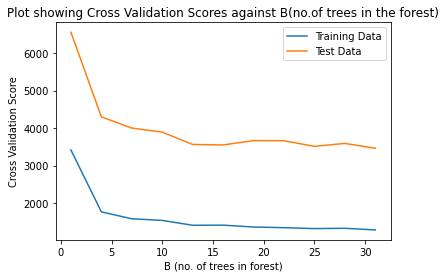

In [29]:
Best_B_train , Best_B_test, scores_train, scores_test = choose_best_B2(X_nano_arr, y_nano_arr, folds_indexes2, np.arange(1, 32,3), plott =True)

0it [00:00, ?it/s]

CV_ACC@B=1 test: 6483.703 , CV_ACC@B=1 train: 3432.857
CV_ACC@B=4 test: 4330.883 , CV_ACC@B=4 train: 1819.137
CV_ACC@B=7 test: 3542.765 , CV_ACC@B=7 train: 1534.093
CV_ACC@B=10 test: 3845.095 , CV_ACC@B=10 train: 1403.497
CV_ACC@B=13 test: 3789.725 , CV_ACC@B=13 train: 1392.471
CV_ACC@B=16 test: 3439.952 , CV_ACC@B=16 train: 1385.235
CV_ACC@B=19 test: 3555.766 , CV_ACC@B=19 train: 1342.608
CV_ACC@B=22 test: 3531.381 , CV_ACC@B=22 train: 1306.200
CV_ACC@B=25 test: 3574.816 , CV_ACC@B=25 train: 1353.438
CV_ACC@B=28 test: 3446.164 , CV_ACC@B=28 train: 1311.196
CV_ACC@B=31 test: 3532.051 , CV_ACC@B=31 train: 1320.983


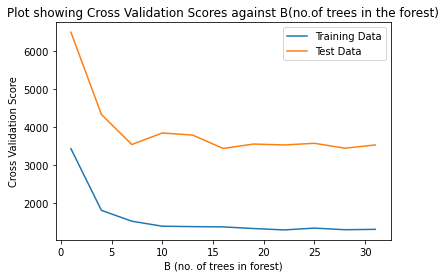

In [30]:
Best_B_train , Best_B_test, scores_train, scores_test = choose_best_B2(X_nano_arr, y_nano_arr, folds_indexes2, np.arange(1, 32,3), plott =True)

The above two plots show appear to show volatility when calculating cross validation scores so we consider an average of multiple iterations to determine the best B

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

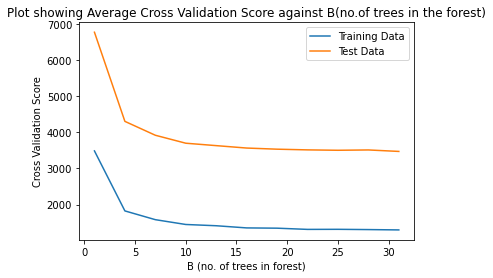

In [31]:
Best_B_train_avg , Best_B_test_avg, scores_train_avg, scores_test_avg = choose_best_B2_avg(X_nano_arr, y_nano_arr, folds_indexes2, np.arange(1, 32,3), 10, plottt =True)

In [32]:
print(Best_B_train_avg , Best_B_test_avg)
Best_B = Best_B_test_avg 

31 31


Construct a Random Forest using unstandardised data and print the MSE and R-sqauared values for the unstandardised test and training data.

In [33]:
forest1 = train_rf(Best_B, 4, X_nano, y_nano,  columns_dict)
y_nano_pred_rf = predict_rf(forest1, X_nano)
y_nano_pred_test_rf = predict_rf(forest1, X_nano_test) 

In [34]:
print(f'MSE when predicting training data class:{rf_score(forest1, X_nano, y_nano)}')
print(f'R-squared value when predicting training data class:{r2_score(y_nano, y_nano_pred_rf)}')
print(f'MSE when predicting test data class:{rf_score(forest1, X_nano_test.to_numpy(), y_nano_test.to_numpy())}')
print(f'R-squared value when predicting test data class:{r2_score(y_nano_test, y_nano_pred_test_rf)}')

MSE when predicting training data class:1315.1381740967322
R-squared value when predicting training data class:0.8015565744646196
MSE when predicting test data class:3714.0949523153545
R-squared value when predicting test data class:0.43743699508809


Construct a Random Forest using standardised data and print the MSE and R-sqauared values for the standardised test and training data.

In [35]:
forest2 = train_rf(Best_B, 4, X_nano_std, y_nano,  columns_dict)
y_nano_pred_rf2 = predict_rf(forest2, X_nano_std)
y_nano_pred_test_rf2 = predict_rf(forest2, X_nano_test_std) 

In [36]:
print(f'MSE when predicting standardised training data class:{rf_score(forest2, X_nano_std, y_nano)}')
print(f'R-squared value when predicting standardised training data class:{r2_score(y_nano, y_nano_pred_rf2)}')
print(f'MSE when predicting standardised test data class:{rf_score(forest2, X_nano_test_std.to_numpy(), y_nano_test.to_numpy())}')
print(f'R-squared value when standardised predicting test data class:{r2_score(y_nano_test, y_nano_pred_test_rf2)}')

MSE when predicting standardised training data class:1351.4295306835754
R-squared value when predicting standardised training data class:0.7960805102302546
MSE when predicting standardised test data class:2794.375805504799
R-squared value when standardised predicting test data class:0.5767441408524219


Construct an ensemble of decision trees(a collection of trees without feature bagging) using unstandardised data and print MSE and R-squared values for the unstandardised test and training data.

In [37]:
forest_ensemble = train_rf(Best_B, 12, X_nano, y_nano,  columns_dict)
y_nano_pred_ens = predict_rf(forest_ensemble, X_nano)
y_nano_pred_test_ens = predict_rf(forest_ensemble, X_nano_test)

In [38]:
print(f'MSE when predicting standardised training data class:{rf_score(forest_ensemble, X_nano, y_nano)}')
print(f'R-squared value when predicting standardised training data class:{r2_score(y_nano, y_nano_pred_ens)}')
print(f'MSE when predicting standardised test data class:{rf_score(forest_ensemble, X_nano_test.to_numpy(), y_nano_test.to_numpy())}')
print(f'R-squared value when standardised predicting test data class:{r2_score(y_nano_test, y_nano_pred_test_ens)}')

MSE when predicting standardised training data class:1024.9354674259716
R-squared value when predicting standardised training data class:0.8453457521690371
MSE when predicting standardised test data class:3068.4670322383254
R-squared value when standardised predicting test data class:0.535228351377228


Construct an ensemble of decision trees (a collection of trees without feature bagging) using standardised data and print MSE and R-squared values for the standardised test and training data.

In [39]:
forest_ensemble2 = train_rf(Best_B, 12, X_nano_std, y_nano,  columns_dict)
y_nano_pred_ens2 = predict_rf(forest_ensemble2, X_nano_std)
y_nano_pred_test_ens2 = predict_rf(forest_ensemble2, X_nano_test_std)

In [40]:
print(f'MSE when predicting standardised training data class:{rf_score(forest_ensemble2, X_nano_std, y_nano)}')
print(f'R-squared value when predicting standardised training data class:{r2_score(y_nano, y_nano_pred_ens2)}')
print(f'MSE when predicting standardised test data class:{rf_score(forest_ensemble2, X_nano_test_std.to_numpy(), y_nano_test.to_numpy())}')
print(f'R-squared value when standardised predicting test data class:{r2_score(y_nano_test, y_nano_pred_test_ens2)}')

MSE when predicting standardised training data class:1045.0178614734723
R-squared value when predicting standardised training data class:0.8423154857329838
MSE when predicting standardised test data class:3192.1218542610777
R-squared value when standardised predicting test data class:0.5164987202983022


We note that utilising optimal B for random forests produces better values with regards to MSE and R-squared when predicting the test data and training data in comparison to the decision tree predictions.

While the lower training data scores could have been may be explained due to potentially overfitting the model to the data, random forrests are near impossible to overfit. The reduced disparity between the MSE and R-squared values between the test and training data predictions. This is further supported by considering the cross validation scores when picking optimal B by noting the asymptotic nature of the outputs and the similarities between the test and training data plots r the cross validation scores.

The ensemble model serves as an improved decision tree model in that while it lacks the feature bagging of the random forests, it considers B number of trees with all features. This would make them susceptable to overfitting. This theory may be further supported by noting the reduced MSE when predicting the training data when compared to the decision tree model with minimal change in the MSE's when prediciting the Test data.


<a name="task-113"></a>

### (1.1.3) [(index)](#index-task-113)

Define a function that chooses the best max depth and min samples leaf while using some fixed B

In [41]:
def choose_best_md_ms(X_train, y_train, folds, B, max_depth_values, min_samples_leaf_values, Print = False):
  md_ms_scores = np.zeros((len(max_depth_values),len(min_samples_leaf_values)))

  unique_combinations = []
  for i in range(len(max_depth_values)):
    for j in range(len(min_samples_leaf_values)):
        unique_combinations.append((max_depth_values[i], min_samples_leaf_values[j]))
  
  for u in tqdm(unique_combinations):
    md_ms_scores[np.where(max_depth_values==u[0]), np.where(min_samples_leaf_values==u[1])], thing = rf_cross_validation_score2(X_train, y_train, folds, B, u[0], u[1])


    if Print == True:
      print(f'score max_depth={u[0]}, min_sample_leaf={u[1]}:{md_ms_scores[np.where(max_depth_values==u[0]), np.where(min_samples_leaf_values==u[1])]} ')

  best_md_ms_index = np.unravel_index(md_ms_scores.argmin(), md_ms_scores.shape)                       # returns the array indexing of the smallest argument
  #print(best_md_ms_index)
  return max_depth_values[best_md_ms_index[0]], min_samples_leaf_values[best_md_ms_index[1]], md_ms_scores

Determine the optimal max depth and min samples leaf

In [42]:

Best_md, Best_ms, md_ms_scores_agg = choose_best_md_ms(X_nano_arr, y_nano_arr, folds_indexes2,Best_B, np.arange(1,15,2), np.arange(1,15,2), Print = True)
print(Best_md,Best_ms)

  0%|          | 0/49 [00:00<?, ?it/s]

score max_depth=1, min_sample_leaf=1:[[6598.13554713]] 
score max_depth=1, min_sample_leaf=3:[[6595.72779324]] 
score max_depth=1, min_sample_leaf=5:[[6601.18992505]] 
score max_depth=1, min_sample_leaf=7:[[6602.22866681]] 
score max_depth=1, min_sample_leaf=9:[[6602.90040369]] 
score max_depth=1, min_sample_leaf=11:[[6607.55468543]] 
score max_depth=1, min_sample_leaf=13:[[6601.97935685]] 
score max_depth=3, min_sample_leaf=1:[[5939.80754005]] 
score max_depth=3, min_sample_leaf=3:[[3446.55352763]] 
score max_depth=3, min_sample_leaf=5:[[3408.10981947]] 
score max_depth=3, min_sample_leaf=7:[[3503.3573698]] 
score max_depth=3, min_sample_leaf=9:[[3566.25930893]] 
score max_depth=3, min_sample_leaf=11:[[3412.20794271]] 
score max_depth=3, min_sample_leaf=13:[[3473.53687739]] 
score max_depth=5, min_sample_leaf=1:[[5926.22208219]] 
score max_depth=5, min_sample_leaf=3:[[3565.02423084]] 
score max_depth=5, min_sample_leaf=5:[[3467.2137559]] 
score max_depth=5, min_sample_leaf=7:[[3401.84

Plot Max depth and min sample leaf scores 

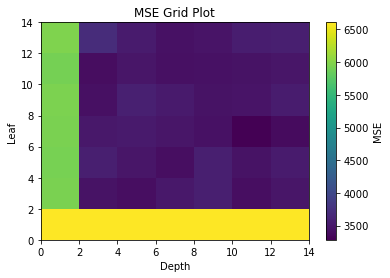

In [43]:
depth_values = np.arange(1, 15, 2)
leaf_values = np.arange(1, 15, 2)

depth, leaf = np.meshgrid(depth_values, leaf_values)

# Create a color plot of the MSE values
plt.pcolormesh(depth, leaf, md_ms_scores_agg, cmap='viridis')
plt.colorbar(label='MSE')
plt.xlabel('Depth')
plt.ylabel('Leaf')
plt.title('MSE Grid Plot')
plt.show()

The plotted data suggest that Low leaf values produce the worst cross validation scores followed by low depth values. However we also observe that there is a rapid convergence to more optimal values.

An important consideration with regard to the convergence is the importance of the min leaf values as they serve to prune the constructed trees of the forest. Which is to say they prevent overfitting and likely explain why the scores asymptote at the shown values when min leaf and max depth instead of reducing the cross validation scores and overfitting to the training data.

While having calculated the 'Best B' value earlier, it would likely have been more optimal to have calculated every combination of the three hyper parameters at the same time. It is also worth noting that due to the seemingly asymptotic nature of the cross validation scores, optimal hyper parameters are of lesser importance than finding hyperparameter values that are sufficiently close to the aymptotic cost value whilst minimising computation costs when training and predicting via the model.

Perform Out of Bagging

In [44]:
forest9, imp_features = train_rf(Best_B, 4, X_nano_std, y_nano,  columns_dict, sample_weights=None, depth=1, max_depth= Best_md, min_samples_leaf = Best_ms,OOB = True )

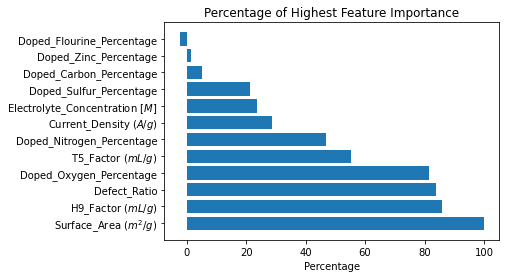

In [45]:
ordered_indexes = np.argsort(imp_features)[::-1]
test_data_headings = nano_data.columns[ordered_indexes]

percentages = (imp_features / np.max(imp_features)) * 100
sorted_indices = np.argsort(percentages)[::-1]

plt.barh(test_data_headings, percentages[sorted_indices])
plt.xlabel('Percentage')
plt.title('Percentage of Highest Feature Importance')
plt.show()

Out of Bagging tellls us that Surface Area is seemingly the most important feature followed closely by Defect Ratio and H9 factor. This would imply that these features have the greatest impact on the capacitance however an important note is that due to the randomness of random forest generation, further iterations may not necessarily reflect the same results.
However the high weighting on a few samples may serve to explain why the random forest model was the best model out of those discussed thus far as it only considers 4 features per tree.



---



<a name="task-12"></a>

## (1.2) Multi-layer Perceptron [(index)](#index-task-12)

Define a function that returns the r squared score

In [46]:
def r2_score(y, y_hat):

    y = y.reshape(y_hat.shape)
    y_bar = y.mean()

    ss_tot = ((y - y_bar)**2).sum()
    ss_res = ((y - y_hat)**2).sum()
    return 1 - (ss_res/ss_tot)

<a name="task-121"></a>

### (1.2.1) [(index)](#index-task-121)

Define a function regarding the Dense Layer that returns the layer preactivations.

In [47]:
def dense(X, W, b):
    a = np.vstack([W @ x + b for x in X])
    return a

Define the activation function.

In [48]:
def act_func(x):
    return np.arctan(x) * np.log(np.abs(x) + 1)

Plot the Activation Function

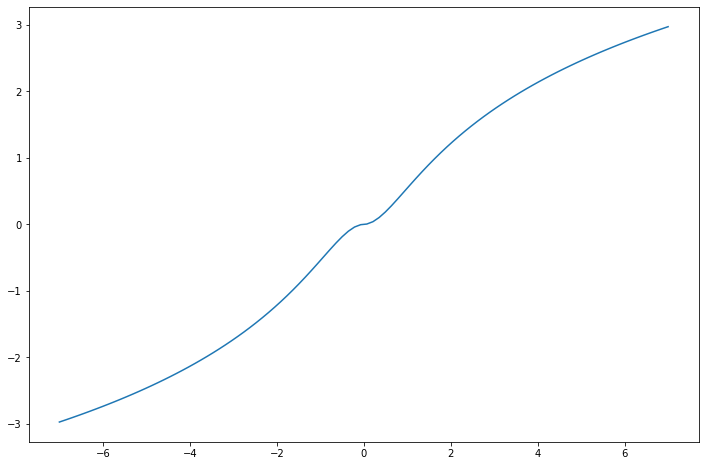

In [49]:
plt.figure(figsize=(12, 8))
plt.plot( np.linspace(-7,7,100),act_func(np.linspace(-7,7,100)))

By analysing the plot of the activation function we observe that it may have the ability to classify data due to the somewhat asymptotic tails which are effectively reducing the weightings assigned to values that deviate from 0.

Define a function that returns the grad of the activation function

In [51]:
def grad_act_func(x):
    return  ((x*np.arctan(x)) / (np.abs(x) * (np.abs(x) + 1))) + (np.log(np.abs(x) + 1) / (x**2 + 1))

In [52]:
act_table = {
    "tomato": act_func,
    "identity": lambda x: x  
}

# A lookup table for gradient of activation functions by their names.
grad_act_table = {
    "tomato": grad_act_func,
    "identity": lambda x: np.ones_like(x)
}

In [53]:
class MLP:
    def __init__(self, seed=42):
        self.layers = []
        self.rng = np.random.default_rng(seed)

    def n_parameters(self):
        """Return the total number of parameters of weights and biases."""
        return sum(l["b"].size + l["W"].size for l in self.layers)

    def n_layers(self):
        """Return current number of MLP layers."""
        return len(self.layers)

    def layer_dim(self, index):
        """Retrieve the dimensions of the MLP layer at `index`."""
        return self.layers[index]["W"].shape

    def add_layer(self, in_dim, out_dim, activation="identity"):
        """Add fully connected layer to MLP.

        Parameters:
            in_dim (int): The output dimension of the layer.
            out_dim (int): The input dimension of the layer.
            activation (str): The activation function name.
        """
        # check if input-dimension matches output-dimension of previous layer
        if self.n_layers() > 0:
            last_out_dim, _ = self.layer_dim(-1)
            assert in_dim == last_out_dim, f"Input-dimension {in_dim} does not match output-dimension {last_out_dim} of previous layer."

        # the first layer, in our convention illustrated, does not apply activation on the input features X.
        if self.n_layers() == 0:
            assert activation == "identity", "Should not apply activations on the input features X, use Identity function for the first layer."


        # store each layer as a dictionary in the list, as shown in the
        # attached diagram.
        self.layers.append({
            # only for debugging.
            "index": len(self.layers),
            # apply Glorot initialisation for weights.
            "W": self.rng.normal(size=(out_dim, in_dim)) * np.sqrt(2. / (in_dim + out_dim)),
            # initialise bias vector with zeros.
            "b": np.zeros(out_dim), ## <-- SOLUTION
            "vW": np.zeros((out_dim, in_dim)),
            "vb": np.zeros(out_dim),
            # store the activation function (as string)
            "activation": activation
        })

    def predict(self, X):
        # We assume that we work with a batch of examples (ndim==2).
        if X.ndim == 1:
            # If one example passed, add a dummy dimension for the batch.
            X = X.reshape(1, -1)

        # store pre- and post-activations in list
        forward_pass = [{"index": 0, "a": X, "h": X}]

        # iterate through hidden layers
        for k in range(1, len(self.layers)):
            # compute pre-activations
            a = dense(forward_pass[k - 1]["h"], self.layers[k - 1]["W"], self.layers[k - 1]["b"])
            activation = act_table[self.layers[k]["activation"]]
            forward_pass.append({"index": k, "a" : a, "h" : activation(a)})

        y_hat = dense(forward_pass[-1]["h"], self.layers[-1]["W"], self.layers[-1]["b"])
        # predicted target is output of last layer
        return y_hat, forward_pass

Define a Loss function (MSE)

In [54]:
def mse_loss(y_true, y_pred):
    assert y_true.size == y_pred.size, "Ground-truth and predictions have different dimensions."

    # Adjustment to avoid subtraction between (K,) and (1, K) arrays.
    y_true = y_true.reshape(y_pred.shape)


    return np.mean((y_true - y_pred)**2, keepdims=True) ## <-- SOLUTION

Define the grad of the Loss function

In [55]:
def grad_mse_loss(y_true, y_pred):
    # Adjustment to avoid subtraction between (K,) and (1, K) arrays.
    y_true = y_true.reshape(y_pred.shape)

    return 2.0 * (y_pred - y_true) / y_true.size ## <-- SOLUTION

Define a backpropogate function

In [56]:
def backpropagate(layers, forward_pass, delta_output):
    # Create a list that will contain the gradients of all the layers.
    delta = delta_output

    assert len(layers) == len(forward_pass), "Number of layers is expected to match the number of forward pass layers"

    # Iterate on layers backwardly, from output to input.
    # Calculate gradients w.r.t. weights and biases of each level and store in list of dictionaries.
    gradients = []
    for layer, forward_computes in reversed(list(zip(layers, forward_pass))):
        assert forward_computes["index"] == layer["index"], "Mismatch in the index."

        h = forward_computes["h"]
        assert delta.shape[0] == h.shape[0], "Mismatch in the batch dimension."


        gradients.append({"W" : delta.T @ h, 
                          "b" : delta.sum(axis=0)}) 

        # Update the delta for the next iteration
        grad_activation_f = grad_act_table[layer["activation"]]
        grad_activation = grad_activation_f(forward_computes["a"])

        # Calculate the delta for the backward layer.
        delta = np.stack([np.diag(gi) @ layer["W"].T @ di
                           for (gi, di) in zip(grad_activation, delta)])


    # Return now ordered list matching the layers.
    return list(reversed(gradients))

Define a function for a Stochastic Gradient Descent step 

In [57]:
def sgd_step(X, y, mlp, momentum=False, learning_rate = 5e-5, beta = 0.4):
    # Compute the forward pass.
    y_hat, forward_pass = mlp.predict(X) ## <-- SOLUTION.

    # Compute the partial derivative of the loss w.r.t. to predictions `y_hat`.
    delta_output = grad_mse_loss(y, y_hat) ## <-- SOLUTION

    # Apply backpropagation algorithm to compute the gradients of the MLP parameters.
    gradients = backpropagate(mlp.layers, forward_pass, delta_output) 

    # mlp.layers and gradients are symmetric, as shown in the figure.
    updated_layers = []
    for layer, grad in zip(mlp.layers, gradients):
        if momentum:
            vW = beta * layer["vW"] + learning_rate * grad["W"]
            vb = beta * layer["vb"] + learning_rate * grad["b"]
            W = layer["W"] - vW ## <-- SOLUTION.
            b = layer["b"] - vb ## <-- SOLUTION.
            updated_layers.append({"W": W, "b": b, "vW":vW, "vb":vb,
                                # keep the activation function.
                                "activation": layer["activation"],
                                # We use the index for asserts and debugging purposes only.
                                "index": layer["index"]})
        else:
            W = layer["W"] - learning_rate * grad["W"]
            b = layer["b"] - learning_rate * grad["b"]
            updated_layers.append({"W": W, "b": b,
                                # keep the activation function.
                                "activation": layer["activation"],
                                # We use the index for asserts and debugging purposes only.
                                "index": layer["index"]})
    return updated_layers

Define a Stochastic Gradient Descent function

In [58]:
def sgd(X_train, y_train, X_test, y_test, mlp, momentum=False, learning_rate = 5e-5,
        n_epochs=300, minibatchsize=8, seed=42):


    # get random number generator
    rng = np.random.default_rng(seed)

    # compute number of iterations per epoch
    n_iterations = int(len(y_train) / minibatchsize)

    # store losses
    losses_train = []
    losses_test = []

    epochs_bar = tqdm(range(n_epochs))
    for i in epochs_bar:

        # shuffle data
        p = rng.permutation(len(y_train))
        X_train_shuffled = X_train[p]
        y_train_shuffled = y_train[p]

        for j in range(n_iterations):
            # get batch
            X_batch = X_train_shuffled[j*minibatchsize : (j+1)*minibatchsize]
            y_batch = y_train_shuffled[j*minibatchsize : (j+1)*minibatchsize]

            # apply sgd step
            updated_layers = sgd_step(X_batch, y_batch, mlp, momentum, learning_rate) ## <-- SOLUTION.

            # update weights and biases of MLP
            mlp.layers = updated_layers ## <-- SOLUTION.

        # compute loss at the end of each epoch
        y_hat_train, _ = mlp.predict(X_train)
        losses_train.append(mse_loss(y_train, y_hat_train).squeeze())
        y_hat_test, _ = mlp.predict(X_test)
        losses_test.append(mse_loss(y_test, y_hat_test).squeeze())
        epochs_bar.set_description(f'train_loss: {losses_train[-1]:.2f}, '
                                   f'test_loss: {losses_test[-1]:.2f}, '
                                   f'train_R^2: {r2_score(y_train, y_hat_train):.2f} '
                                   f'test_R^2: {r2_score(y_test, y_hat_test):.2f} ')
    return mlp, losses_train, losses_test

Construct MLP and check no. of trainable parameters

In [59]:
my_MLP = MLP(seed=2)
my_MLP.add_layer(12, 50)
my_MLP.add_layer(50, 50, "tomato")
my_MLP.add_layer(50, 1, "tomato")


print("Number of layers:", my_MLP.n_layers())
print("Number of trainable parameters:", my_MLP.n_parameters())

Number of layers: 3
Number of trainable parameters: 3251


In [60]:
print("Number of weights between layers:", 12*50 + 50*50 + 50*1)
print("Number of weights within nodes:", 50 + 50 + 1)
print("Total of weights:",12*50 + 50*50 + 50*1 + 50 + 50 + 1)


Number of weights between layers: 3150
Number of weights within nodes: 101
Total of weights: 3251


In [61]:
n_epochs = 300
mlp, losses_train, losses_test = sgd(X_nano_std.to_numpy(), y_nano_arr, X_nano_test_std.to_numpy(), y_nano_test.to_numpy(),
                                     my_MLP, momentum=False, learning_rate = 5e-5,
                                     n_epochs=n_epochs,
                                     minibatchsize=8)

  0%|          | 0/300 [00:00<?, ?it/s]

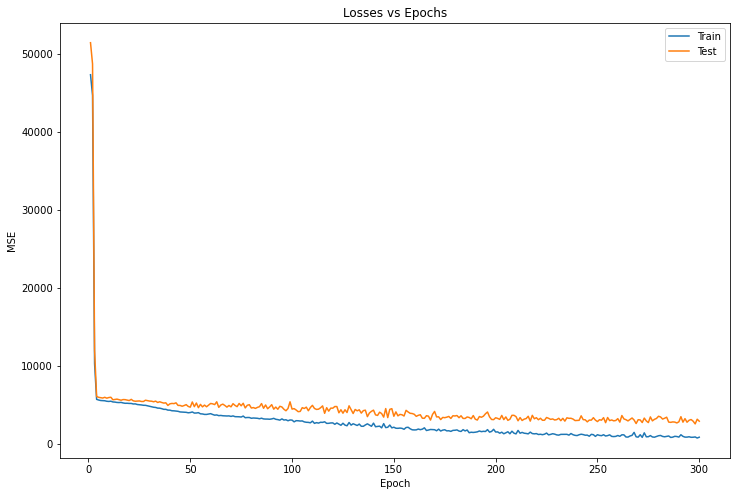

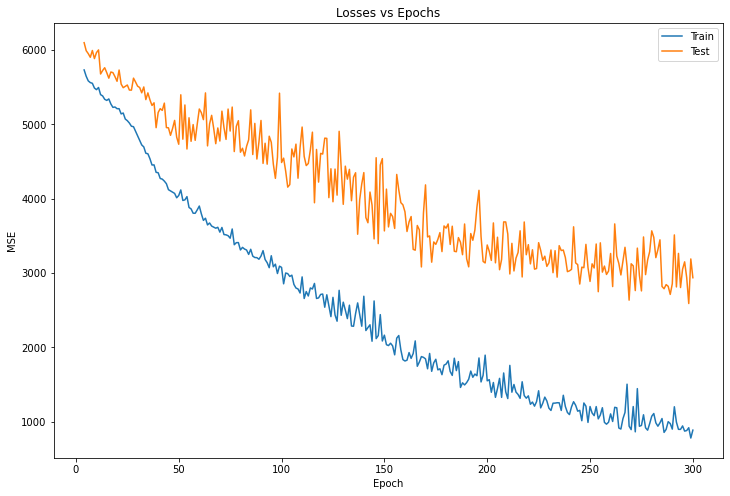

In [62]:
# plot training progress
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(np.arange(1,1+n_epochs),losses_train, label="Train")
ax.plot(np.arange(1,1+n_epochs),losses_test, label="Test")
ax.set(title="Losses vs Epochs", xlabel = "Epoch", ylabel = "MSE") 
ax.legend()
plt.show()

# plot training progress
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(np.arange(4,1+n_epochs),losses_train[3:], label="Train")
ax.plot(np.arange(4,1+n_epochs),losses_test[3:], label="Test")
ax.set(title="Losses vs Epochs", xlabel = "Epoch", ylabel = "MSE") 
ax.legend()
plt.show()

Calculate R-squared score and MSE

In [63]:
y_pred_mlp_test = mlp.predict(X_nano_test_std.to_numpy())[0]
y_pred_mlp = mlp.predict(X_nano_std.to_numpy())[0]

print(f'MSE when predicting standardised training data class:{mse_loss(y_nano.to_numpy(), y_pred_mlp)}')
print(f'R-squared value when predicting standardised training data class:{r2_score(y_nano.to_numpy(), y_pred_mlp)}')
print(f'MSE when predicting standardised test data class:{mse_loss(y_nano_test.to_numpy(), y_pred_mlp_test)}')
print(f'R-squared value when standardised predicting test data class:{r2_score(y_nano_test.to_numpy(), y_pred_mlp_test)}')

MSE when predicting standardised training data class:[[885.4434687]]
R-squared value when predicting standardised training data class:0.8663939360085707
MSE when predicting standardised test data class:[[2936.77010938]]
R-squared value when standardised predicting test data class:0.5551760957439025


The generalisation power of a model refers to the ability to predict unseen data. In this case we refer to the MSE and R-squared scores when predicting the unseen test data where we observe better values when models considered in Q1.1. Albeit it is worth noting the smaller MSE's.

Furthermore the discrepency between te scores for the predictions of the training and test data appear to suggest some level of overfitting potentially due to a lack of implementing methods such as early stop times.

<a name="task-122"></a>

### (1.2.2) [(index)](#index-task-122)

In [64]:
my_MLP2 = MLP(seed=2)
my_MLP2.add_layer(12, 50)
my_MLP2.add_layer(50, 50, "tomato")
my_MLP2.add_layer(50, 1, "tomato")

print("Number of layers:", my_MLP2.n_layers())
print("Number of trainable parameters:", my_MLP2.n_parameters())

Number of layers: 3
Number of trainable parameters: 3251


In [65]:
n_epochs = 300
mlp2, losses_train2, losses_test2 = sgd(X_nano_std.to_numpy(), y_nano.to_numpy(), X_nano_test_std.to_numpy(), y_nano_test.to_numpy(),
                                     my_MLP2, momentum=True, learning_rate = 5e-5,
                                     n_epochs=n_epochs,
                                     minibatchsize=8) 

  0%|          | 0/300 [00:00<?, ?it/s]

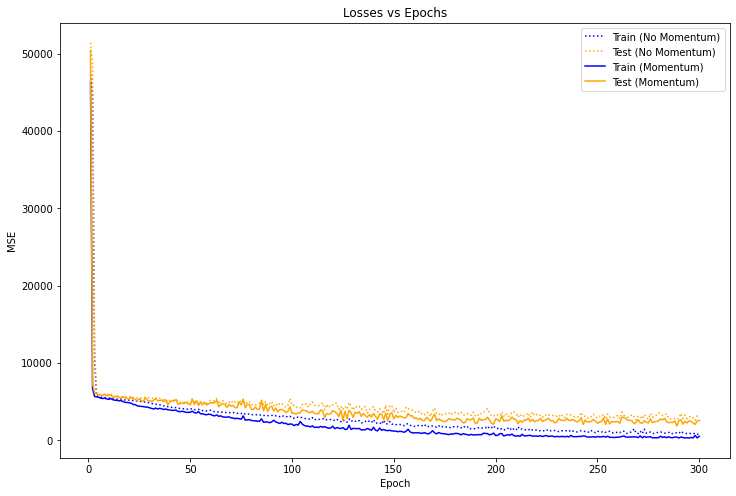

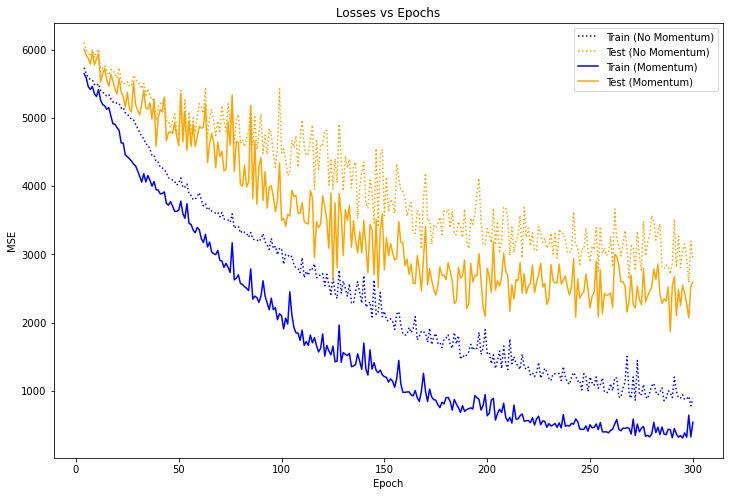

In [66]:
# plot training progress
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(np.arange(1,301),losses_train, label="Train (No Momentum)", color='blue', linestyle='dotted')
ax.plot(np.arange(1,301),losses_test, label="Test (No Momentum)", color = 'orange', linestyle='dotted')
ax.plot(np.arange(1,301),losses_train2, label="Train (Momentum)", color = 'blue', linestyle='solid')
ax.plot(np.arange(1,301),losses_test2, label="Test (Momentum)", color = 'orange', linestyle='solid')
ax.set(title="Losses vs Epochs", xlabel = "Epoch", ylabel = "MSE") 
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(np.arange(4,301),losses_train[3:], label="Train (No Momentum)", color='blue', linestyle='dotted')
ax.plot(np.arange(4,301),losses_test[3:], label="Test (No Momentum)", color = 'orange', linestyle='dotted')
ax.plot(np.arange(4,301),losses_train2[3:], label="Train (Momentum)", color = 'blue', linestyle='solid')
ax.plot(np.arange(4,301),losses_test2[3:], label="Test (Momentum)", color = 'orange', linestyle='solid')
ax.set(title="Losses vs Epochs", xlabel = "Epoch", ylabel = "MSE") 
ax.legend()
plt.show()

In [67]:
y_pred_mlp_test2 = mlp2.predict(X_nano_test_std.to_numpy())[0]
y_pred_mlp2 = mlp2.predict(X_nano_std.to_numpy())[0]

print(f'MSE when predicting standardised training data class:{mse_loss(y_nano.to_numpy(), y_pred_mlp2)}')
print(f'R-squared value when predicting standardised training data class:{r2_score(y_nano.to_numpy(), y_pred_mlp2)}')
print(f'MSE when predicting standardised test data class:{mse_loss(y_nano_test.to_numpy(), y_pred_mlp_test2)}')
print(f'R-squared value when standardised predicting test data class:{r2_score(y_nano_test.to_numpy(), y_pred_mlp_test2)}')

MSE when predicting standardised training data class:[[537.87460435]]
R-squared value when predicting standardised training data class:0.9188391903622435
MSE when predicting standardised test data class:[[2591.40385907]]
R-squared value when standardised predicting test data class:0.607487702760471


By observing our plots we may gather that using momentum increases the speed of convergence of the model with respect to when momentum is not used. This may be explained by considering how momentum functions in that it takes averages of previous steps optimal directions, to reduce the overshooting from the zig-zagging effect in order to find a better approximation for the optimal descent directions for the parameters. This would suggest faster convergence as observed by the plot.


We observe similar MSE values in the momentum method when compared to the random forests method and MLP without momentum, however they prove to be slightly better with the same behavior being observed for the R-squared scores. When considering the MSE and R-squared values on the training data we observe low MSE values and very high R-squared values which may be indicative overfitting potentially due to a lack of employing methods such as weight decay. It should also be noted that with a relatively small data set with respect to the number of features which may also serve as a culprit for overfitting when using MLP models which random forests are less susceptible to and the idea of having potentially overfit our MLP models are further supported by the large disparity between MSE values when predicting the training and testing data sets.


With regards to the plots themselves we see the higher epochs result in lower MSE which suggest successful implementation of gradient descent. Furthermore the massive difference between the initial weightings and optimal weightings for the model enable large changes through back propagation allowing for faster convergence.


To conclude, when comparing random forests, MLP with momentum and MLP without momentum, MLP with momentum appears to exhibit the best generalization power, which is to say that it exhibits the best ability to predict unseen data and is thus the best model.


<a name="task-123"></a>

### (1.2.3) [(index)](#index-task-123)

Define a function that extends features to include quadratic features

In [68]:
def quad_lin_reg_extend(X):

    a, b = np.triu_indices(np.shape(X)[1], 0)

    return np.hstack([X, X[:,a] * X[:,b]])

In [69]:
quad_lin_reg_extend(X_nano_std.to_numpy()).shape

(558, 90)

Define a function that returns optimised parameters using ridge regression.

In [70]:
def ridge_estimate(X, y, penalty):

    N, D = X.shape

    X_aug = np.hstack([np.ones((N,1)), X]) # augmented training inputs of size N x (D+1)
    
    N_aug, D_aug = X_aug.shape
    
    I = np.identity(D_aug)
    
    I[0] = 0.0 # penalty excludes the bias term.
    
    beta_ridge = np.linalg.solve(X_aug.T @ X_aug + penalty * I, X_aug.T @ y) ## <-- SOLUTION
    
    return beta_ridge

Plot the ridge regression coefficients for Linear regression wth Quadratic basis Functions  

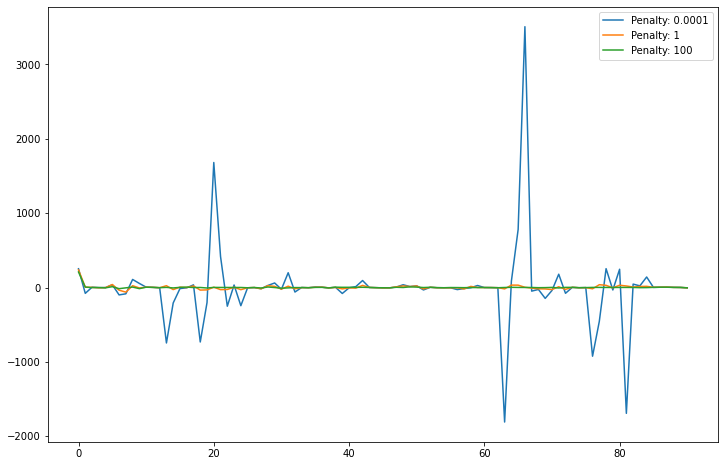

In [71]:
fig, ax = plt.subplots(figsize=(12, 8))
H = len(quad_lin_reg_extend(X_nano_std.to_numpy())[1])
penalties = [0.0001, 1, 100]
for penalty in penalties:
    y_pred = ridge_estimate(quad_lin_reg_extend(X_nano_std.to_numpy()), y_nano.to_numpy(), penalty)
    ax.plot(np.arange(0, 90+1), y_pred, label=f"Penalty: {penalty}")

ax.legend()
ax.set_xlabel='Quadratic Basis Function Coefficients (Indexed)'
ax.set_ylabel='Beta Coefficients'
plt.show()

The penalty determines how high variance between different features is penalised. A higher penalty values will penalise greater discrepencies in variation between features which should ultimately lead to lower coefficients. This has been reflected in our plot where our Beta coefficients are scaled down significantly when considering high penalties.

Implement a function that returns a cross validation score.

In [72]:
def cross_validation_score_rr(X_train, y_train, folds, penalty, quadratic = False):
    scores = []
    for i in range(len(folds)):
            # choose the indexes corresponding to the ith fold
        val_indexes = folds[i]

        # the training set indexes consist of all indexes not included in the val set indexes - so we use the set operator to remove them
        train_indexes = list(set(range(y_train.shape[0])) - set(val_indexes))

        # X_train_i = X_train.loc[train_indexes]
        # y_train_i = y_train.loc[train_indexes]
        X_train_i = X_train[train_indexes,:]
        y_train_i = y_train[train_indexes]

        # X_val_i = X_train.loc[val_indexes]
        # y_val_i = y_train.loc[val_indexes]
        X_val_i = X_train[val_indexes,:] 
        y_val_i = y_train[val_indexes]
        
        if quadratic == True:
          beta = ridge_estimate(quad_lin_reg_extend(X_train_i), y_train_i, penalty)
          score_itest = mse(y_val_i, np.hstack([np.ones((X_val_i.shape[0],1)), quad_lin_reg_extend(X_val_i)]) @ beta)

        else:
          beta = ridge_estimate(X_train_i, y_train_i, penalty)
          score_itest = mse(y_val_i, np.hstack([np.ones((X_val_i.shape[0],1)), X_val_i]) @ beta)

          
        scores.append(score_itest)

  # Return the average score
    return np.mean(scores)

Implement a function that chooses the best penalty

In [73]:
def choose_best_penalty(X_train, y_train, folds_indexes, penalties, quadratic = False, printt = False):
    
    scores = []
    
    for penalty in penalties:

        scores.append(cross_validation_score_rr(X_train, y_train, folds_indexes, penalty, quadratic = quadratic))
        
        if printt == True:
            print(f'CV_ACC@l={penalty}: {scores[-1]:.3f}')
    return scores

Plot MSE against Penalties for Ridge Regression on the original features

Best penalty for Linear regression:  85.99381843535865


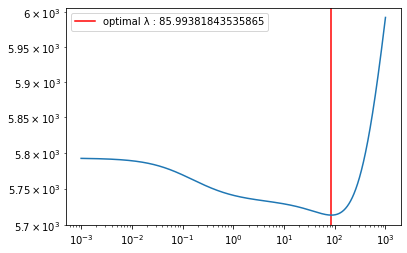

In [74]:
penalties = np.logspace(-3, 3, 2000)

folds_pen = cross_val_split(len(y_nano_arr), 5)
#print(folds_pen)

penalty_scores = choose_best_penalty(X_nano_std.to_numpy(), y_nano.to_numpy(), folds_pen, penalties)
opt_penalty = penalties[np.argmin(penalty_scores)]
print("Best penalty for Linear regression: ", opt_penalty)
plt.axvline(opt_penalty, color='red', label = f'optimal λ : {opt_penalty}')
plt.loglog(penalties, penalty_scores)
plt.legend()
plt.show()

In [75]:
X_nano_test_std_arr = X_nano_test_std.to_numpy()
X_Aug_test = np.hstack([np.ones((X_nano_test_std_arr.shape[0],1)),X_nano_test_std.to_numpy()])
y_pred8 = X_Aug_test @ ridge_estimate(X_nano_test_std_arr, y_nano_test.to_numpy(),opt_penalty)
thing2 = r2_score(y_nano_test.to_numpy(),y_pred8)
thing3 = mse_loss(y_nano_test.to_numpy(),y_pred8)

print(f'r-squared for ridge regression using penalty on original features {thing2}')
print(f'MSE for ridge regression using penalty on original features {thing3}')


r-squared for ridge regression using penalty on original features 0.2249440763481554
MSE for ridge regression using penalty on original features [5116.99359656]


Plot MSE against Penalties for Ridge Regression on the Quadratic Basis Function features

Best penalty for Linear regression:  229.44592035995024


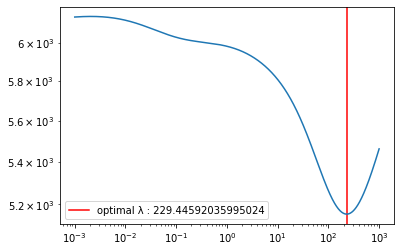

In [76]:
penalty_scores2 = choose_best_penalty(X_nano_std.to_numpy(), y_nano.to_numpy(), folds_pen, penalties, quadratic = True)
opt_penalty2 = penalties[np.argmin(penalty_scores2)]
print("Best penalty for Linear regression: ", opt_penalty2)
plt.axvline(opt_penalty2, color='red', label = f'optimal λ : {opt_penalty2}')
plt.loglog(penalties, penalty_scores2)
plt.legend()
plt.show()

In [77]:
X_nano_test_std_arr2 = X_nano_test_std.to_numpy()
X_Aug_test2 = np.hstack([np.ones((X_nano_test_std_arr2.shape[0],1)),X_nano_test_std.to_numpy()])
y_pred9 = X_Aug_test2 @ ridge_estimate(X_nano_test_std_arr2, y_nano_test.to_numpy(),opt_penalty2)
thing4 = r2_score(y_nano_test.to_numpy(),y_pred9)
thing5 = mse_loss(y_nano_test.to_numpy(),y_pred9)

print(f'r-squared for ridge regression using penalty on original features {thing4}')
print(f'MSE for ridge regression using penalty on original features {thing5}')

r-squared for ridge regression using penalty on original features 0.14613222964006545
MSE for ridge regression using penalty on original features [5637.31697276]




---



<a name="task-2"></a>

# (2) Task 2: Classification [(index)](#index-task-2)

In [78]:
# Read Data
cancer_data = pd.read_csv('./brain_cancer_samples.csv')
cancer_data_test = pd.read_csv('./brain_cancer_test.csv')#

# Check data
print(cancer_data.shape)

# Remove unnecessary Columns
cancer_data.pop('Patient ID')
cancer_data_test.pop('Patient ID')

# Check Data
print(cancer_data.shape)
print(cancer_data_test.shape)
cancer_data.tail(10)

(145, 12)
(145, 11)
(60, 11)


,2D Surface,Contour Size,Total Surface,Density,Diameter,Primary Axis,Shape Variation,Location,Eccentricity_Real,Eccentricity_Imag,Class
135,3294.5,1147.075244,46929.5,0.070201,64.766409,288.832275,329.591522,0,3.370000e-17,0.549681,1
136,65.5,44.041630,81.5,0.803681,9.132206,5.336360,22.184971,2,2.470000e-16,4.035262,0
137,1104.0,178.994948,1456.5,0.757981,37.492085,27.980013,65.539291,4,1.300000e-16,2.118173,1
138,746.0,126.225396,846.5,0.881276,30.819421,24.991606,43.875553,1,8.840000e-17,1.442973,1
139,122204.5,3547.416636,222439.0,0.549384,394.456084,393.556366,649.100708,4,8.030000e-17,1.311587,1
140,61.5,31.899495,65.5,0.938931,8.848968,9.686973,12.779761,4,5.270000e-17,0.860512,0
141,1933.0,171.681239,1972.5,0.979975,49.610201,43.783520,57.397675,1,5.190000e-17,0.847685,1
142,1187.0,581.455844,1959.0,0.605921,38.875897,9.854265,277.515595,0,1.720000e-15,28.144217,1
143,8056.0,640.724959,13503.5,0.596586,101.277923,81.612198,212.267380,1,1.470000e-16,2.401004,1
144,613.0,154.710677,947.0,0.647307,27.937356,25.551823,48.472477,1,9.870000e-17,1.612051,1


Here we have made the decision to remove patient ID's as this information appears to be irrelevant when considering the class of the data (prescence/ type of cancer). It may also be worth noting that we have minimal information regarding how location is measured as it is seemingly categorical. This may imply that particular areas of the body are grouped into a particular class for the locations however, we lack information on the distinction between locations. In particular we lack information as to how the distance between location classes is measured, e.g: are any two classes roughly equidistant from one another or is class 2 twice as far from class 0 as class 1 is from class 0. We have however decided to include location data in our features due to potential links to the class of the data, although no alternative measure has been imposed on this particular feature due to the lack of information regarding how it has been recorded.

<a name="task-21"></a>

## (2.1) k-Nearest Neighbours [(index)](#index-task-21)

<a name="task-211"></a>

### (2.1.1) [(index)](#index-task-211)

Seperate Class of data from the Features

In [79]:
# Features of sample data
cancer_X = cancer_data.copy()

# Class' of sample data
cancer_y = cancer_X.pop('Class')

# Features of sample data
cancer_X_test = cancer_data_test.copy()

# Class' of sample data
cancer_y_test = cancer_X_test.pop('Class').to_numpy()

#cancer_X_test
cancer_X_test = cancer_X_test.to_numpy()

Define a notion of distance: We shall utilise Euclidean distance

In [80]:
def euclidian_distance(p, q):
    return np.sqrt(np.sum((p-q)**2, axis=1))

Define a function that returns us the K nearest neighbours using our chosen distance function

In [81]:
# returns the indices of the k nearest points to the test set froim the training set
def k_neighbours(X_train, X_test, distance, k=5, return_distance=False):
    '''
    Args:
        X_train: our training set
        X_test: our test set
        k: the number of neighbours we choose
        return_distance: determines whether we also output the associated distances of the k nearest neighbours to the point
        distance: a function denoting how we define distance

    Return:
        neighbour_indices: the indices of the data points considered to be the K nearest neighbours
        distances: the distances associated with the above indices from our chosen data points   
    '''
    dist = []
    neigh_ind = []
  
    # an array with inputs denoting the distance between the ith entry of x_test and the jth entry of X-train
    #print(X_test)
    point_dist = [distance(x_test, X_train) for x_test in X_test] 

    # determine which k training points are closest to each test point - each row denotes a particular test point
    for row in point_dist:
        enum_neigh = enumerate(row)       # assigns an integer starting from 0 to each entry in the row - each entry now has two dimensions (indice, old entry) s.t old entry = distance from test_point
        sorted_neigh = sorted(enum_neigh, key=lambda x: x[1])[:k]       # sorted sorts the input according to some key - the key controls how the entries are sorted (apply the key then do ascending order for the output)
                                                                        # the key here is a lambda function - applied to the x. and return x[1] i.e: the old entry
                                                                        # so we sort enum_neigh entries according to the values of the old entry, i.e: according to distance from the test point

        ind_list = [tup[0] for tup in sorted_neigh]                       # returns the list of ordered indices indices of the closest point to the furthest point
        dist_list = [tup[1] for tup in sorted_neigh]                      # returns the list of ordered distances - closest point to furthest point

        dist.append(dist_list)                                            # should have an array telling us the distances to points arranged by closest 
        neigh_ind.append(ind_list)                                        # corresponding indices denoting what points
   
    # return distances together with indices of k nearest neighbours if the chosen input is TRUE
    if return_distance:
        return np.array(dist), np.array(neigh_ind)
  
    return np.array(neigh_ind)

Define a function that predicts the class of some data using its k nearest neighbours from the training data

In [82]:
def predict(X_train, y_train, X_test, k=5):
  '''
  Arg:
    X_train: our training data's features
    y_train: our training data's class'
    X_test: data that we want to predict the class of
    k: the number of neighbours we want to work with

  Return:  
    y_pred:a vector containng predictions of the classes of X_test
  
  '''

  # Determine the k nearest neighbours of the x_test set using the x training set
  neighbours = k_neighbours(X_train,X_test,euclidian_distance, k=k)

  # now we need to predict the class of each y point using the y training set
  y_pred = np.array([np.argmax(np.bincount(y_train[neighbour])) for neighbour in neighbours])                 
  # we take the most frequently occuring ----- np.argmax
  # class     ----- np.bincount
  # from the neighbour points chosen from the training set     ------- y_train[neighbour]
  # but we must consider all k neaarest neighbours for a given y prediction point - i.e: along each rows
  # but also for every single y prediction - i.e: for every row

  return y_pred

Define a score function to evaluate how good our model is at predicting the class of our data

In [83]:
def score_classify(X_train, y_train, X_test, y_test, predict_func, k=5):
  
  # predict the y values
  y_pred = predict_func(X_train, y_train, X_test, k=k)

  return np.mean(y_pred==y_test)

We want to determine the optimal number of neighbours to utilise in our function so we employ T-fold cross validation.
Define a function that returns scores for a given k and number of folds

In [84]:
def cross_validation_score(X_train, y_train, folds, k, predict_func):
  scores = []
  for i in range(len(folds)):

    # choose the indexes corresponding to the ith fold
    val_indexes = folds[i]

    # the training set indexes consist of all indexes not included in the val set indexes - so we use the set operator to remove them
    train_indexes = list(set(range(y_train.shape[0])) - set(val_indexes))

    
    # Create training sets
    X_train_i = X_train[train_indexes, :]
    y_train_i = y_train[train_indexes]

    # Create test sets
    X_val_i = X_train[val_indexes, :] 
    y_val_i = y_train[val_indexes] 

    score_i = score_classify(X_train_i, y_train_i, X_val_i, y_val_i, predict_func, k=k) 
    scores.append(score_i)

  # Return the average score
  return np.mean(scores) 

Define a function that chooses the best k by comparing the accuracy of a range of k's

In [85]:
def choose_best_k(X_train, y_train, folds, k_range, predict_func):
  k_scores = np.zeros((len(k_range),))
  
  for i, k in enumerate(k_range):
    k_scores[i] = cross_validation_score(X_train, y_train, folds, k, predict_func)
    print(f'CV_ACC@k={k}: {k_scores[i]:.3f}')

  best_k_index = np.argmax(k_scores)
  
  return k_range[best_k_index]

Find the best k for our data set

In [86]:
np.random.seed(4)
# shuffling the rows in X and y
cancer_data_shuff = cancer_data.sample(frac = 1)
cancer_X_shuff = cancer_data_shuff[cancer_data_shuff.columns[:-1]].to_numpy()
cancer_y_shuff = cancer_data_shuff[cancer_data_shuff.columns[-1]].to_numpy()

In [87]:


# standardise our sample data
cancer_X_shuff_std = standardise(cancer_X_shuff)

# standardise our test data
cancer_X_test_std = standardise(cancer_X_test, cancer_X_shuff)

# Create 5 folds
cancer_folds_indexes = np.split(np.arange(len(cancer_y_shuff)), 5)

Best_K = choose_best_k(cancer_X_shuff_std, cancer_y_shuff, cancer_folds_indexes, np.arange(1, 31),predict)

f'Best k is: {Best_K}'

CV_ACC@k=1: 0.628
CV_ACC@k=2: 0.634
CV_ACC@k=3: 0.683
CV_ACC@k=4: 0.655
CV_ACC@k=5: 0.703
CV_ACC@k=6: 0.662
CV_ACC@k=7: 0.676
CV_ACC@k=8: 0.676
CV_ACC@k=9: 0.676
CV_ACC@k=10: 0.648
CV_ACC@k=11: 0.662
CV_ACC@k=12: 0.634
CV_ACC@k=13: 0.641
CV_ACC@k=14: 0.648
CV_ACC@k=15: 0.634
CV_ACC@k=16: 0.621
CV_ACC@k=17: 0.621
CV_ACC@k=18: 0.607
CV_ACC@k=19: 0.634
CV_ACC@k=20: 0.634
CV_ACC@k=21: 0.579
CV_ACC@k=22: 0.607
CV_ACC@k=23: 0.572
CV_ACC@k=24: 0.579
CV_ACC@k=25: 0.572
CV_ACC@k=26: 0.579
CV_ACC@k=27: 0.566
CV_ACC@k=28: 0.559
CV_ACC@k=29: 0.531
CV_ACC@k=30: 0.538


'Best k is: 5'

Define a function that returns true positives, true negatives, false positives and false negatives for a given class

In [88]:
#function that returns the tp, tn, fp, fn for a given class
def get_tp_tn_fp_fn(y_test, y_pred, class_label):

    tp = np.sum((y_test==class_label) & (y_pred==class_label))

    tn = np.sum((y_test!=class_label) & (y_pred!=class_label))

    fp = np.sum((y_test!=class_label) & (y_pred==class_label))

    fn = np.sum((y_test==class_label) & (y_pred!=class_label))
    
    return tp, tn, fp, fn

Define a function that returns the precision, accuracy and class weighted accuracy for any given class

In [89]:
def get_potatos(y_test, y_pred, class_labels, print_metrics = False):
    macro_precision = 0
    macro_accuracy = 0
    class_weighted_precision = 0
    class_weighted_accuracy = 0
    weights = np.bincount(y_test)/len(y_test)
    tp_sum = 0
    fp_sum = 0
    for class_label in class_labels:
        tp, tn, fp, fn = get_tp_tn_fp_fn(y_test, y_pred, class_label)
        macro_accuracy += (tp+tn)/(tp+tn+fp+fn)
        macro_precision += tp/(tp+fp)
        tp_sum += tp
        fp_sum += fp
        class_weighted_precision += tp/(tp+fp)*weights[class_label]
        class_weighted_accuracy += (tp+tn)/(tp+tn+fp+fn)*weights[class_label]
    macro_accuracy /= len(class_labels)                        
    macro_precision /= len(class_labels)
    micro_accuracy = np.sum(y_test==y_pred)/len(y_test)  
    micro_precision = tp_sum/(tp_sum+fp_sum)

    mp = macro_precision

    if print_metrics == True:
        print(f'macro precision = {macro_precision}')
        print(f'micro precision = {micro_precision}')
        print(f'class weighted precision = {class_weighted_precision}')
        print(f'macro accuracy = {macro_accuracy}')
        print(f'micro accuracy = {micro_accuracy}')
        print(f'class weighted accuracy = {class_weighted_accuracy}')

    return macro_precision, macro_accuracy, micro_precision, micro_accuracy, class_weighted_precision, class_weighted_accuracy

In [90]:
y_test_pred = predict(cancer_X_shuff_std, cancer_y_shuff, cancer_X_test_std, k=Best_K)

In [91]:
info1 = get_potatos(cancer_y_test, y_test_pred, np.arange(0,3), print_metrics = True)

macro precision = 0.753968253968254
micro precision = 0.6833333333333333
class weighted precision = 0.6908730158730159
macro accuracy = 0.7888888888888888
micro accuracy = 0.6833333333333333
class weighted accuracy = 0.7294444444444445


Identify the minority class

In [92]:
count_things = np.bincount(cancer_y_shuff)


print('Class counts are:' ,np.bincount(cancer_y_shuff))
print(f'Minority class is {np.argmin(count_things)}')

Class counts are: [47 80 18]
Minority class is 2


Observing the counts of the class's it is quick to see that the minority class is 2 with class 1 significantly outweighing the other 2 class's.

We observe relatively high macro precision and accuracy wth respect to the micro precision and accuracies which imply that the under represented classes (i.e: class 0 and 2) have relatively good precision and accuracy when compared to the majority class 1. This is as macro averages evenly weight classes and do not take into account the population of each class whilst micro-averages give even weighting on individuals and thus result in higher majority class representation. 

<a name="task-212"></a>

### (2.1.2) [(index)](#index-task-212)

Implement Weighted KNN - suffices to change our predict function as the K nearest neighbours well remain unchanged

In [93]:
def weighted_predict(X_train, y_train, X_test, k=5):
  '''
  Arg:
    X_train: our training data's features
    y_train: our training data's class'
    X_test: data that we want to predict the class of
    k: the number of neighbours we want to work with

  Return:  
    y_pred:a vector containng predictions of the classes of X_test
  
  '''

  # Determine the k nearest neighbours of the x_test set using the x training set
  distances,neighbours = k_neighbours(X_train,X_test,euclidian_distance, k=k, return_distance=True)

 # Determine the classes that appear in t neighbours
  unique_values = np.unique(y_train[neighbours])
  
  # Calculate weights
  eps = 1e-16
  #weightss = 1/(distances+eps)**2
  weightss = 1 - np.bincount(y_train, minlength = 3)/len(y_train)

  
  # now we need to predict the class of each y point using the y training set
  #y_pred = np.array([np.argmax(np.bincount(y_train[neighbour],weights = weightss[i], minlength = 3)) for i,neighbour in enumerate(neighbours)]) 
  y_pred = np.array([np.argmax(weightss*np.bincount(y_train[neighbour], minlength = 3)) for i,neighbour in enumerate(neighbours)])                
  
  # we take the most frequently occuring ----- np.argmax
  # class     ----- np.bincount
  # from the neighbour points chosen from the training set     ------- y_train[neighbour]
  # but we must consider all k neaarest neighbours for a given y prediction point - i.e: along each rows
  # but also for every single y prediction - i.e: for every row

  return y_pred

This choice of weighting was chosen to balance out the imbalanced data set. In particular the weighting provides a higher weight to classes that have a smaller number of occurences within the data set and should thus hypothetically allow us to more accurately predict any minority classes. Our weights are 1 - frequency for each class.

Compute a weighted KNN model and its' associated metrics

In [94]:
y_test_pred_w = weighted_predict(cancer_X_shuff_std, cancer_y_shuff, cancer_X_test_std,k=Best_K)
info_w = get_potatos(cancer_y_test, y_test_pred_w, np.arange(0,3), print_metrics=True)

macro precision = 0.641959972394755
micro precision = 0.6333333333333333
class weighted precision = 0.6545893719806763
macro accuracy = 0.7555555555555555
micro accuracy = 0.6333333333333333
class weighted accuracy = 0.6930555555555556


In [95]:
cross_validation_score(cancer_X_shuff_std, cancer_y_shuff, cancer_folds_indexes, Best_K, weighted_predict)

0.6827586206896552

By analysing the metrics of the weighted KNN model and the KNN model we observe that weighted KNN does marginally worse in terms of all aspects of the defined metrics. suggesting that weighted KNN using these particular class weights is a worse model in general.However it is worth noting that we maintain a high macro accuracy with it experiencing a relatively small drop with respect to the other metrics in comparison to the KNN metrics. 

<a name="task-213"></a>

### (2.1.3) [(index)](#index-task-213)

2-step prediction

In [96]:
def predict_2step(cancer_data_training, cancer_data_testing):

    cancer_data_no2 = cancer_data.copy()
    cancer_data_no2.loc[cancer_data_no2['Class']==2, 'Class'] = 1

    cancer_data_test_no2 = cancer_data_test.copy()
    cancer_data_test_no2.loc[cancer_data_test_no2['Class']==2, 'Class'] = 1

    # Features and Class of test data without Class 2
    cancer_X_test_no2 = cancer_data_test_no2.copy()
    cancer_y_test_no2 = cancer_X_test_no2.pop('Class').to_numpy()
    cancer_X_test_no2 = cancer_X_test_no2.to_numpy()

    # shuffling the data points and create X(features) and y(Class)
    cancer_data_no2_shuff = cancer_data_no2.sample(frac = 1)
    cancer_X_no2_shuff = cancer_data_no2_shuff[cancer_data_no2_shuff.columns[:-1]].to_numpy()
    cancer_y_no2_shuff = cancer_data_no2_shuff[cancer_data_no2_shuff.columns[-1]].to_numpy()

    # standardise our sample data
    cancer_X_no2_shuff_std = standardise(cancer_X_no2_shuff)

    # standardise our test data
    cancer_X_test_no2_std = standardise(cancer_X_test_no2,cancer_X_no2_shuff)


    # Define a data set discluding data points with class = 0
    cancer_data_no0 = cancer_data.copy()
    cancer_data_no0 = cancer_data_no0.drop(cancer_data_no0[cancer_data_no0['Class']==0].index)

    cancer_data_test_no0 = cancer_data_test.copy()
    cancer_data_test_no0 = cancer_data_test_no0.drop(cancer_data_test_no0[cancer_data_test_no0['Class']==0].index)

    # Features and Class of test data discluding data points with class 0
    cancer_X_test_no0 = cancer_data_test_no0.copy()
    cancer_y_test_no0 = cancer_X_test_no0.pop('Class').to_numpy()
    cancer_X_test_no0 = cancer_X_test_no0.to_numpy()

    # shuffling the data points and create X(features) and y(Class)
    cancer_data_no0_shuff = cancer_data_no0.sample(frac = 1)
    cancer_X_no0_shuff = cancer_data_no0_shuff[cancer_data_no2_shuff.columns[:-1]].to_numpy()
    cancer_y_no0_shuff = cancer_data_no0_shuff[cancer_data_no2_shuff.columns[-1]].to_numpy()

    # standardise our sample data
    cancer_X_no0_shuff_std = standardise(cancer_X_no0_shuff)

    # standardise our test data
    cancer_X_test_no0_std = standardise(cancer_X_test_no0,cancer_X_no0_shuff)


    # Determine 
    y_test_pred_no2 = predict(cancer_X_no2_shuff_std, cancer_y_no2_shuff, cancer_X_test_no2_std, k=1)

    preds = y_test_pred_no2
    indices = np.argwhere(y_test_pred_no2 == 1)
    indices = indices.reshape(len(indices))
    preds[indices] = predict(cancer_X_no0_shuff_std, cancer_y_no0_shuff,cancer_X_test_std[indices],k=1)

    return preds 

In [97]:
step_preds = predict_2step(cancer_data, cancer_data_test)

Check Metrics using 2-step

In [98]:
info_2s = get_potatos(cancer_y_test, step_preds, np.arange(0,3), print_metrics= True)

macro precision = 0.7914230019493177
micro precision = 0.7333333333333333
class weighted precision = 0.7451754385964913
macro accuracy = 0.8222222222222223
micro accuracy = 0.7333333333333333
class weighted accuracy = 0.7783333333333333


The two step model is the best model with respect to the six metrics with their being somewhat even improvements accross the board.This suggestests that the model improved at getting true positives and true negatives in general as opposed to improving at producing any individual class.

This coincides with our general understanding of what two step is. It is in general easier to seperate between two classes at a time (i.e: between cancer and not cancer) than it is to sort into 3 seperate classes.



---



<a name="task-22"></a>

## (2.2) Logistic regression vs kernel logistic regression [(index)](#index-task-22)

In [99]:
np.random.seed(2)

cancer_data_no2 = cancer_data.copy()
cancer_data_no2.loc[cancer_data_no2['Class']==2, 'Class'] = 1

cancer_data_test_no2 = cancer_data_test.copy()
cancer_data_test_no2.loc[cancer_data_test_no2['Class']==2, 'Class'] = 1

# Features and Class of test data without Class 2
cancer_X_test_no2 = cancer_data_test_no2.copy()
cancer_y_test_no2 = cancer_X_test_no2.pop('Class').to_numpy()
cancer_X_test_no2 = cancer_X_test_no2.to_numpy()

# shuffling the data points and create X(features) and y(Class)
cancer_data_no2_shuff = cancer_data_no2.sample(frac = 1)
cancer_X_no2_shuff = cancer_data_no2_shuff[cancer_data_no2_shuff.columns[:-1]].to_numpy()
cancer_y_no2_shuff = cancer_data_no2_shuff[cancer_data_no2_shuff.columns[-1]].to_numpy()

# standardise our sample data
cancer_X_no2_shuff_std = standardise(cancer_X_no2_shuff)

# standardise our test data
cancer_X_test_no2_std = standardise(cancer_X_test_no2,cancer_X_no2_shuff)

<a name="task-221"></a>

### (2.2.1) [(index)](#index-task-221)

Define logistic functions

In [100]:
def logistic(z):
    return 1/(1 + np.exp(-z))

def predict_log(X, beta):
       
    y_log =logistic(X@beta) 
    return y_log.squeeze()

Define a function to initialise the size of the parameters of our model

In [101]:
def initialise(size):
    """    
    Argument:
    size: Size of the parameter vector beta
  
    Returns:
    beta: Initialised vector of shape (size, 1)
    """
  
    beta = np.zeros((size, 1))
  
    return beta

Define a function that returns the Grads and Loss function values to be utilised in Stochastic Gradient Descent

In [102]:
def propagate(X, y, beta, lambd):
    """
    Arguments:
    X: Data of shape (N, p+1)
    y: True label vector of size N
    beta: Parameter vector, a numpy array of size p+1

    Returns:
    mean_loss: Mean sample loss for the negative log-likelihood
    dbeta: Gradient of the mean sample loss with respect to beta

    """
    y_log = predict_log(X, beta)

    # Mean sample loss function
    mean_loss = - np.mean(y * np.log(y_log) + (1-y) * np.log(1-y_log)) + (lambd/2)*np.linalg.norm(beta[1:])**2
    

    # Derivatives
    be = beta.copy()
    be[0] = 0
    dbeta = np.mean(X.T * (y_log - y), axis=1).reshape(-1,1) + lambd*be


    mean_loss = np.squeeze(mean_loss)
  
    # Store gradients in a dictionary
    grads = {'dbeta': dbeta}
  
    return grads, mean_loss

Define a function that optimises our paramenters using Gradient Descent

In [103]:
def optimise(X, y, beta, lambd, num_iterations=1000, learning_rate=0.1, print_loss=False):
    """
    Arguments:
    X: Data of shape (N, p+1)
    y: True label vector of size N
    beta: Parameter vector, a numpy array of size p+1
    num_iterations: Number of iterations
    learning_rate: Step size in updating procedure
    print_loss: 'True' to print the mean loss every 100 iterations

    Returns:
    params: Dictionary containing the parameter vector beta
    grads: Dictionary containing the gradient
    mean_loss_history: List of all the mean loss values computed during the optimisation (can be used to plot the learning curve)

    """
    mean_loss_history = []
    
    num_iterations = int(num_iterations)

    
    for i in range(num_iterations):
        
        # Calculating the loss and gradients (hint: use your existing functions)
        grads, mean_loss = propagate(X,y,beta,lambd)
      
        # Retrieving derivatives from grads
        dbeta = grads['dbeta']
      
        # Updating procedure
        beta = beta - learning_rate * dbeta
      
        # Record the loss values
        if i % 100 == 0:
            mean_loss_history.append(mean_loss)
      
        # Printing the loss every 100 iterations
        if print_loss and i % 100 == 0:
            print ('Mean loss after iteration %i: %f' %(i, mean_loss))
  
    # Saving parameters and gradients in dictionary
    params = {'beta': beta}
    grads = {'dbeta': dbeta}
  
    return params, grads, mean_loss_history

Define a function that predicts the classes of the given data points by inputting the models parameters

In [104]:
def predict_lg(X_test, beta):
    """
    Arguments:
    X_test: Test set of shape (N_test, p+1)
    beta: Parameter vector, a numpy array of size p+1

    Returns:
    y_pred: Vector containing all binary predictions (0/1) for X_test
    
    """
    N_test = X_test.shape[0]
    y_pred = np.zeros((N_test, 1))
    beta = beta.reshape(X_test.shape[1], 1)
  
    # Predicting the probabilities
    y_log = predict_log(X_test, beta)
  
    y_pred = y_log.round()
  
    return y_pred

Define a function that generates a model and returns the accuracies of the model when predicting the class of a test set

In [105]:
def model(X_train, y_train, X_test, y_test, lambd, num_iterations=2000, learning_rate=0.1, print_loss=False):
    # Initialising parameters with zeros
    beta = initialise(X_train.shape[1])

    # Gradient descent
    parameters, grads, mean_loss_history = optimise(X_train, y_train, beta, lambd, num_iterations, learning_rate, print_loss=print_loss)

    # Retrieving parameter vector beta from dictionary 'parameters'
    beta = parameters['beta']

    # Predicting test and training set examples
    y_pred_test = predict_lg(X_test, beta)
    y_pred_train = predict_lg(X_train, beta)

    # Printing train/test accuracy
    print('Training accuracy: {} %'.format(100 - np.mean(np.abs(y_pred_train - y_train)) * 100))
    print('Test accuracy: {} %'.format(100 - np.mean(np.abs(y_pred_test - y_test)) * 100))

    # Saving all the information
    d = {'mean_loss_history': mean_loss_history, 'y_pred_test': y_pred_test, 'y_pred_train': y_pred_train, 'beta': beta, 'learning_rate': learning_rate, 'num_iterations': num_iterations}
    return d

Initialise X_test and X_train with an additional row of ones to allow for Beta0(intercept) to be incorporated into our Matrix equation

In [106]:
cancer_X_no2_shuff_std_new = np.hstack((np.ones((cancer_X_no2_shuff_std.shape[0], 1)), cancer_X_no2_shuff_std))
cancer_X_test_no2_std_new = np.hstack((np.ones((cancer_X_test_no2_std.shape[0], 1)), cancer_X_test_no2_std))

In [107]:
# Running the model
d = model(cancer_X_no2_shuff_std_new, cancer_y_no2_shuff , cancer_X_test_no2_std_new, cancer_y_test_no2, 0.0025, num_iterations=2000, learning_rate=0.1, print_loss=False)

Training accuracy: 77.93103448275862 %
Test accuracy: 83.33333333333334 %


Define a function that gives the Precision, Recall and Area under the curve 

In [108]:
def prc_curve(y_true, y_log):
    """
    Arguments:
    y_true: Ground truth labels with size N
    y_log: Probabilities produced by logistic regression model with size N
  
    Returns:
    auc: Area Under the Curve (AUC)
    tpr_l: List of true positive rate (TPR) values for each scanned threshold
    fpr_l: List of false positive rate (FPR) values for each scanned threshold
    thresholds: Scanned thresholds sorted in decreasing order
    
    """
    # List of distinct values in y_log, sorted sorted in decreasing order
    thresholds = reversed(sorted(set(y_log)))
    recall_l, precision_l = [], []

    for threshold in thresholds:
        # Thresholding
        y_thresholded = (y_log >= threshold)

        # True positives
        tp = np.sum(y_true & y_thresholded)
        # True negatives
        tn = np.sum((~y_true) & (~y_thresholded))
        # False positives
        fp = np.sum((~y_true) & y_thresholded)
        # False negatives
        fn = np.sum(y_true & (~y_thresholded))


        recall = tp / (tp + fn)
        precision = tp / (tp + fp) 
        recall_l.append(recall)
        precision_l.append(precision)

    # Compute AUC using Trapezoidal rule
    auc = np.trapz(precision_l, recall_l)
    return auc, precision_l, recall_l, thresholds

Plot the area under the Precision Recall Curve

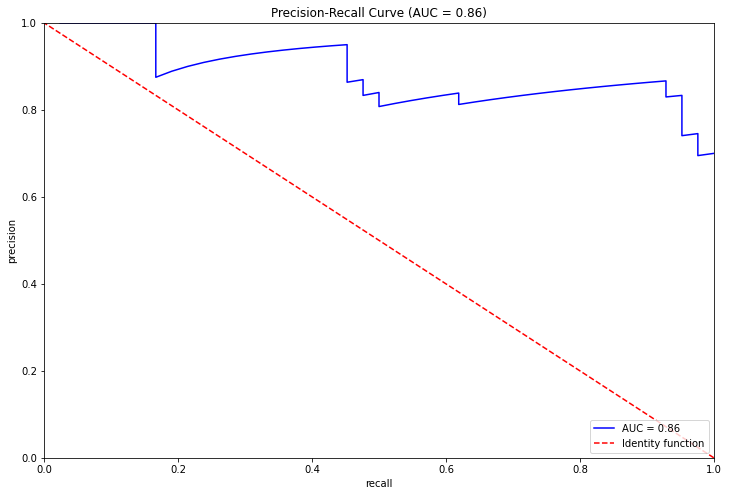

0.8602991324239321


In [109]:
y_log = predict_log(cancer_X_test_no2_std_new, d['beta'])
auc, precision, recall, th = prc_curve(cancer_y_test_no2, y_log)

plt.figure(figsize=(12,8))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot(recall, precision, 'b', label=f'AUC = {auc:0.2f}')
plt.plot([1, 0], [0, 1], 'r--', label='Identity function')
plt.xlabel('recall')
plt.ylabel('precision')
plt.title(f'Precision-Recall Curve (AUC = {auc:0.2f})')
plt.legend(loc='lower right')
plt.show()

print(auc)

Precision refers to a models ability to truly predict a positive, which is to say how often a predicted positive is a true positive. Meanwhile recall is a models ability to detect a positive value. We note that a high precision and recall is particularily useful when working with imbalanced data as it allows one to mre confidently guarantee that any instances of a predicted minority class are true positive predictions. This is useful for our data set due to approximately 30% of the data having class 0 and approximately 70% of the data having class 1. 

It is also worth noting that our model also exhibits relatively high training and testing set prediction accuracies.

Our model exhibits a good AUC score of 0.86 suggesting an ability to fairly accurately predict true values truthfully.



<a name="task-222"></a>

### (2.2.2) [(index)](#index-task-222)

The kernalised Loss function is
$$
- \frac{1}{N}\sum_i(y_i ln(y_{pred,i}) + (1-y_i) ln(1 - y_{pred,i}))+\frac{1}{2}\ \lambda\ u^T K u
$$
where $y_{pred}=\frac{1}{1+e^{-(K^{(i)} u+\beta_0)}}$ with $K^{i}$ i-th row of $k$ 


To prove this is a convex optimisation problem it suffices to prove that the cost function is Convex. We may split the loss function into parts by noting that the sum of convex functions is convex. We will also use the property that the composition of a strictly non-decreasing convex function onto a convex function is convex.

We first consider the term: $\frac{\lambda}{2}u^TKu^T$.

A kernel by definition is semi-positive definite and any quadratic of the above form is convex iff K is semi positive definite (As $\lambda >0$). Thus we have  that $\frac{\lambda}{2}u^TKu^T$ is convex.

For the second part of the loss function it suffices to prove the following expressions are convex functions: $f_1(z) = -\log(\sigma(z))$, $f_1(z) = -\log(\sigma(z))$ where $\sigma(z) = 1/(1+\exp(-z))$ is the logistic function and z is some linear function.

Any linear function is convex and the logistic function is a strictly non-decreasing convex function.  From the above stated properties it suffices to show that $f_1(z)$ and $f_2(z)$ are monotonically increasing convex functions.

As $\frac{d}{dz} f_1(z) = -\exp(-z)/(1+\exp(-z)) = -1 + 1/(1+exp(-z)) = -1 + \sigma(z)$, which is monotonically increasing,  $f_1(z)$ is convex.

Since $f2(z)=f1(z)+z$ we have $f2(z)=−log(exp(−z)/(1+exp(−z)))=log(1+exp(−z))+z=f1(z)+z$, which is monotonically increasing, $f_1(z)$ is convex.

Thus completing our proof.
 

 


<a name="task-223"></a>

### (2.2.3) [(index)](#index-task-223)

Define the Kernel Matrix

In [110]:
def kernel_m(X1,X2,alpha):

    n1,m1 = X1.shape
    n2,m2 = X2.shape
    kernel = np.zeros((n1,n2))

    for i in range(n1):
        exponent = np.sum(np.abs(X2 - X1[i]), axis=1)
        kernel[i,:] = np.exp(-alpha*exponent)

    return kernel

Define a function that calls the logistic function when inputted with the appropriate values

In [111]:
def logistic_inter(K, u, intercept):
    ker_log = logistic(K@u + intercept)
    return ker_log.squeeze()

Define a function that computes the Cost.

In [112]:
def compute_cost_kernel(u, Kernel, y, lambd, intercept=0):

    ker_log = logistic_inter(Kernel,u, intercept)
    
    cost = (- np.mean(y * np.log(ker_log)) + (1-y) * np.log(1-ker_log) + (lambd/2)*u.T@Kernel@u).squeeze()
 
    return cost

Define a function that computes the Grad of the cost with respect to our model parameters

In [113]:
def calculate_cost_gradient_kernel(u, Kernel, y, lambd, intercept=0):

    # if only one example is passed
    if type(y) == np.float64 or type(y) == np.int32:
        y = np.asarray([y])
        Kernel = np.asarray([Kernel])  # returns a multidimensional array to avoid errors in future steps

    ker_log =  logistic_inter(Kernel,u, intercept)
    
    di = np.mean(ker_log - y)
    
    du = np.mean(Kernel.T * (ker_log - y), axis=1).reshape(-1, 1) + lambd * Kernel@u

    return du.reshape(-1,1), di

Define a function that returns the Grads and Loss function values to be utilised in Stochastic Gradient Descent

In [114]:
def propagate_kernel(kernel, y, u, lambd, intercept=0):
    """
    Arguments:
    X: Data of shape (N, p+1)
    y: True label vector of size N
    beta: Parameter vector, a numpy array of size p+1

    Returns:
    mean_loss: Mean sample loss for the negative log-likelihood
    dbeta: Gradient of the mean sample loss with respect to beta

    """
    y_log = logistic_inter(kernel, u, intercept)

    # Mean sample loss function
    mean_loss = compute_cost_kernel(u, kernel, y, lambd, intercept)
    

    # Derivatives
    du,di = calculate_cost_gradient_kernel(u, kernel, y, lambd, intercept)

    mean_loss = np.squeeze(mean_loss)
  
    # Store gradients in a dictionary
    grads = {'du': du, 'di' : di}
  
    return grads, mean_loss

Define a function that optimises our paramenters using Gradient Descent

In [115]:
def optimise_kernel(kernel, y, u, lambd, intercept=0, num_iterations=1000, learning_rate=0.1, print_loss=False):
    """
    Arguments:
    X: Data of shape (N, p+1)
    y: True label vector of size N
    beta: Parameter vector, a numpy array of size p+1
    num_iterations: Number of iterations
    learning_rate: Step size in updating procedure
    print_loss: 'True' to print the mean loss every 100 iterations

    Returns:
    params: Dictionary containing the parameter vector beta
    grads: Dictionary containing the gradient
    mean_loss_history: List of all the mean loss values computed during the optimisation (can be used to plot the learning curve)

    """
    mean_loss_history = []
    
    num_iterations = int(num_iterations)

    
    for i in range(num_iterations):
        
        # Calculating the loss and gradients (hint: use your existing functions)
        grads, mean_loss = propagate_kernel(kernel, y, u, lambd, intercept)
      
        # Retrieving derivatives from grads
        du = grads['du']
        di = grads['di']
      
        # Updating procedure
        u -= learning_rate * du
        intercept -=  learning_rate * di
      
        # Record the loss values
        if i % 100 == 0:
            mean_loss_history.append(mean_loss)
      
        # Printing the loss every 100 iterations
        if print_loss and i % 100 == 0:
            print ('Mean loss after iteration %i: %f' %(i, mean_loss))
  
    # Saving parameters and gradients in dictionary
    params = {'u': u, 'intercept':intercept}
    grads = {'du': du, 'di' : di}
  
    return params, grads, mean_loss_history

Define a function that optimises our paramenters using Gradient Descent

In [116]:
def predict_lg_kernel(kernel, u,intercept):
    """
    Arguments:
    X_test: Test set of shape (N_test, p+1)
    beta: Parameter vector, a numpy array of size p+1

    Returns:
    y_pred: Vector containing all binary predictions (0/1) for X_test
    
    """
    N_test =kernel.shape[0]
    y_pred = np.zeros((N_test, 1))
    u = u.reshape(kernel.shape[1], 1)
    #intercept = intercept.reshape(kernel.shape[0], 1)
  
    # Predicting the probabilities
    y_log = logistic_inter(kernel , u, intercept)
  
    y_pred = y_log.round().reshape(-1,1)
  
    return y_pred

Define a function that generates a model and returns the accuracies of the model when predicting the class of a test set

In [117]:
def model_kernel(X_train, y_train, X_test, y_test, lambd, alpha, num_iterations=2000, learning_rate=0.1, print_loss=False):
    # Initialising parameters with zeros
    u = initialise(X_train.shape[0])
    intercept = 0

    kernel1 = kernel_m(X_train,X_train,alpha)
    kernel2 = kernel_m(X_test, X_train,alpha)


    # Gradient descent
    parameters, grads, mean_loss_history = optimise_kernel(kernel1, y_train, u, lambd, intercept, num_iterations, learning_rate, print_loss=print_loss)

    # Retrieving parameter vector beta from dictionary 'parameters'
    u = parameters['u']
    intercept = parameters['intercept']

    # # Predicting test and training set examples
    y_pred_test = predict_lg_kernel(kernel2, u, intercept).round().reshape(1, -1)
    y_pred_train = predict_lg_kernel(kernel1, u, intercept).round().reshape(1, -1)

    # Printing train/test accuracy
    print('Training accuracy: {} %'.format(100 - np.mean(np.abs(y_pred_train - y_train)) * 100))
    print('Test accuracy: {} %'.format(100 - np.mean(np.abs(y_pred_test - y_test)) * 100))

    # Saving all the information
    d = {'mean_loss_history': mean_loss_history, 'y_pred_test': y_pred_test, 'y_pred_train': y_pred_train, 'u': u, 'learning_rate': learning_rate,'intercept': intercept,'kernel1' : kernel1, 'kernel2' : kernel2, 'num_iterations': num_iterations}
    return d

In [118]:
e = model_kernel(cancer_X_no2_shuff_std, cancer_y_no2_shuff , cancer_X_test_no2_std, cancer_y_test_no2, 0.0025, 0.3, num_iterations=2000, learning_rate=0.1, print_loss=False)

Training accuracy: 86.89655172413794 %
Test accuracy: 80.0 %


In [119]:
f = model_kernel(cancer_X_no2_shuff_std, cancer_y_no2_shuff , cancer_X_test_no2_std, cancer_y_test_no2, 0.0025, 100, num_iterations=2000, learning_rate=0.1, print_loss=False)

Training accuracy: 68.9655172413793 %
Test accuracy: 70.0 %


Plot the area under the Precision Recall Curve

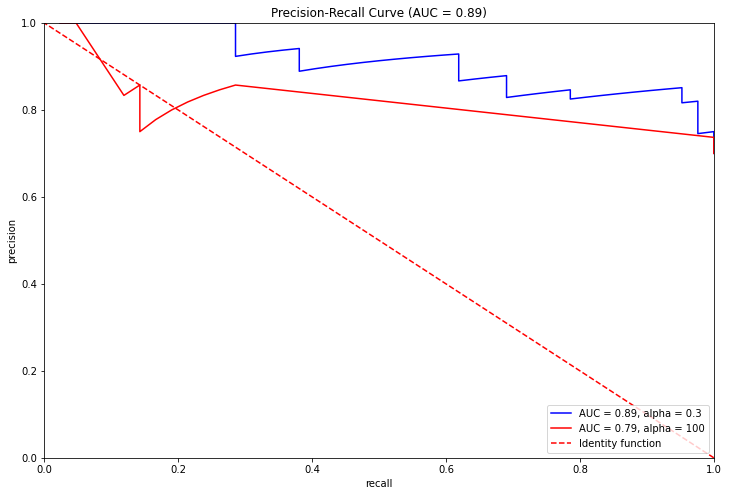

In [120]:
ker_log = logistic_inter(e['kernel2'], e['u'], e['intercept'])
auc, precision, recall, th = prc_curve(cancer_y_test_no2, ker_log)

ker_log2 = logistic_inter(f['kernel2'], f['u'], f['intercept'])
auc2, precision2, recall2, th2 = prc_curve(cancer_y_test_no2, ker_log2)

plt.figure(figsize=(12,8))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot(recall, precision, 'b', label=f'AUC = {auc:0.2f}, alpha = 0.3')
plt.plot(recall2, precision2, 'r', label=f'AUC = {auc2:0.2f}, alpha = 100')
plt.plot([1, 0], [0, 1], 'r--', label='Identity function')
plt.xlabel('recall')
plt.ylabel('precision')
plt.title(f'Precision-Recall Curve (AUC = {auc:0.2f})')
plt.legend(loc='lower right')
plt.show()

We are particularly interested in the shape of the precision-recall curve of our models as it tells us how our model trades how often we predict a true positive for how often we detect a positive value from the training data.

Comparing our two precision-recall curves we are quick to notice how the alpha = 0.3 case exhibits behavior similar to the precision recoil curve without utilising the kernel(as evident by the shapes of the curves). In particular we appear to observe perfect precision at low values of recall and then progressively decreasing Precision values as recall increases. 

However our alpha = 100 exhibits a sharp decrease in precision at low values of recall suggesting that we are trading the ability to predict true positives the majority of the time for a minimal increase in the ability to predict a true value when in appears. However it is worth noting that for high Recall values our alpha = 100 and alpha = 0.3 models have similar precision values.

Although both AUC values may be considered good, the alpha = 0.3 model exhibits the best AUC value out of all 3 plotted models with the difference between the alpha = 0.3 model and the alpha = 100 models being relatively significant in terms of the difference in AUC.

This would lead us to believe that our alpha = 0.3 kernelised model is the best out of the three presented.

